## Investigate the synthetic data generate from gaussian_and_multinomial diffusion

We load the original Adult data as well, such that we can compare to the "ground truth".

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchinfo import summary

import numpy as np
import pandas as pd

# Custom styles and sizing for matplotlib.
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("tex.mplstyle")
from plotting.plotting_utils import set_size

from sklearn import metrics # plot_roc_curve.

from Data import Data, CustomDataset, ToTensor

plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (10, 10)


# SMALL_SIZE = 8
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 25

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [11]:
device = torch.device('cpu') # We don't need GPU in this case (not computationally heavy).
print(f"Using '{device}' device.")

# Set seeds for reproducibility. 
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

categorical_features = ["workclass","marital_status","occupation","relationship", \
                        "race","sex","native_country"]
numerical_features = ["age","fnlwgt","education_num","capital_gain","capital_loss","hours_per_week"]

# Load the real data into the scope. 
adult_data = pd.read_csv("adult_data_no_NA.csv", index_col = 0)
print(adult_data.shape)

Adult = Data(adult_data, categorical_features, numerical_features, scale_version = "quantile", splits = [0.85,0.15])
X_train, y_train = Adult.get_training_data()
X_test, y_test = Adult.get_test_data()
print(X_train.shape)

# Load the synthetic data into the scope. 
synthetic_samples = pd.read_csv("synthetic_sample_both.csv", index_col = 0)
print(synthetic_samples.shape)

# Make sure the data types of the two data sets are the same (just in case)
synthetic_samples[numerical_features] = synthetic_samples[numerical_features].astype("int64")

Using 'cpu' device.
(45222, 14)
Feature 'workclass'' has 7 unique levels
Feature 'marital_status'' has 7 unique levels
Feature 'occupation'' has 14 unique levels
Feature 'relationship'' has 6 unique levels
Feature 'race'' has 5 unique levels
Feature 'sex'' has 2 unique levels
Feature 'native_country'' has 41 unique levels
The sum of all levels is 82. This will be the number of cat-columns after one-hot encoding (non-full rank)
(38438, 13)
(38438, 13)


In [12]:
def plot_categorical_features(synthetic_data, real_data, categorical_features):
    """Plot the categorical features are barplots."""
    fig, axs = plt.subplots(2,2)
    axs = axs.ravel()
    for idx, ax in enumerate(axs):
        (synthetic_data[categorical_features[idx]].value_counts()/synthetic_data.shape[0]*100).plot(kind='bar', ax = ax, label = "Synth.")
        (real_data[categorical_features[idx]].value_counts()/real_data.shape[0]*100).plot(kind='bar', ax = ax, color = "orange", alpha = 0.7, label = "OG.")
        ax.xaxis.set_ticklabels([])
        ax.legend()
        ax.title.set_text(f"% {categorical_features[idx]}")
        
    plt.tight_layout()

    # Make two grids since 7 is not an even number of categorical features. 
    fig, axs2 = plt.subplots(2,2)
    axs2 = axs2.ravel()
    for idx, ax in enumerate(axs2, start = 4):
        if idx > len(categorical_features)-1:
            break
        (synthetic_data[categorical_features[idx]].value_counts()/synthetic_data.shape[0]*100).plot(kind='bar', ax = ax, label = "Synth.")
        (real_data[categorical_features[idx]].value_counts()/real_data.shape[0]*100).plot(kind='bar', ax = ax, color = "orange", alpha = 0.6, label = "OG.")
        ax.xaxis.set_ticklabels([])
        ax.legend()
        ax.title.set_text(f"% {categorical_features[idx]}")
    plt.tight_layout()

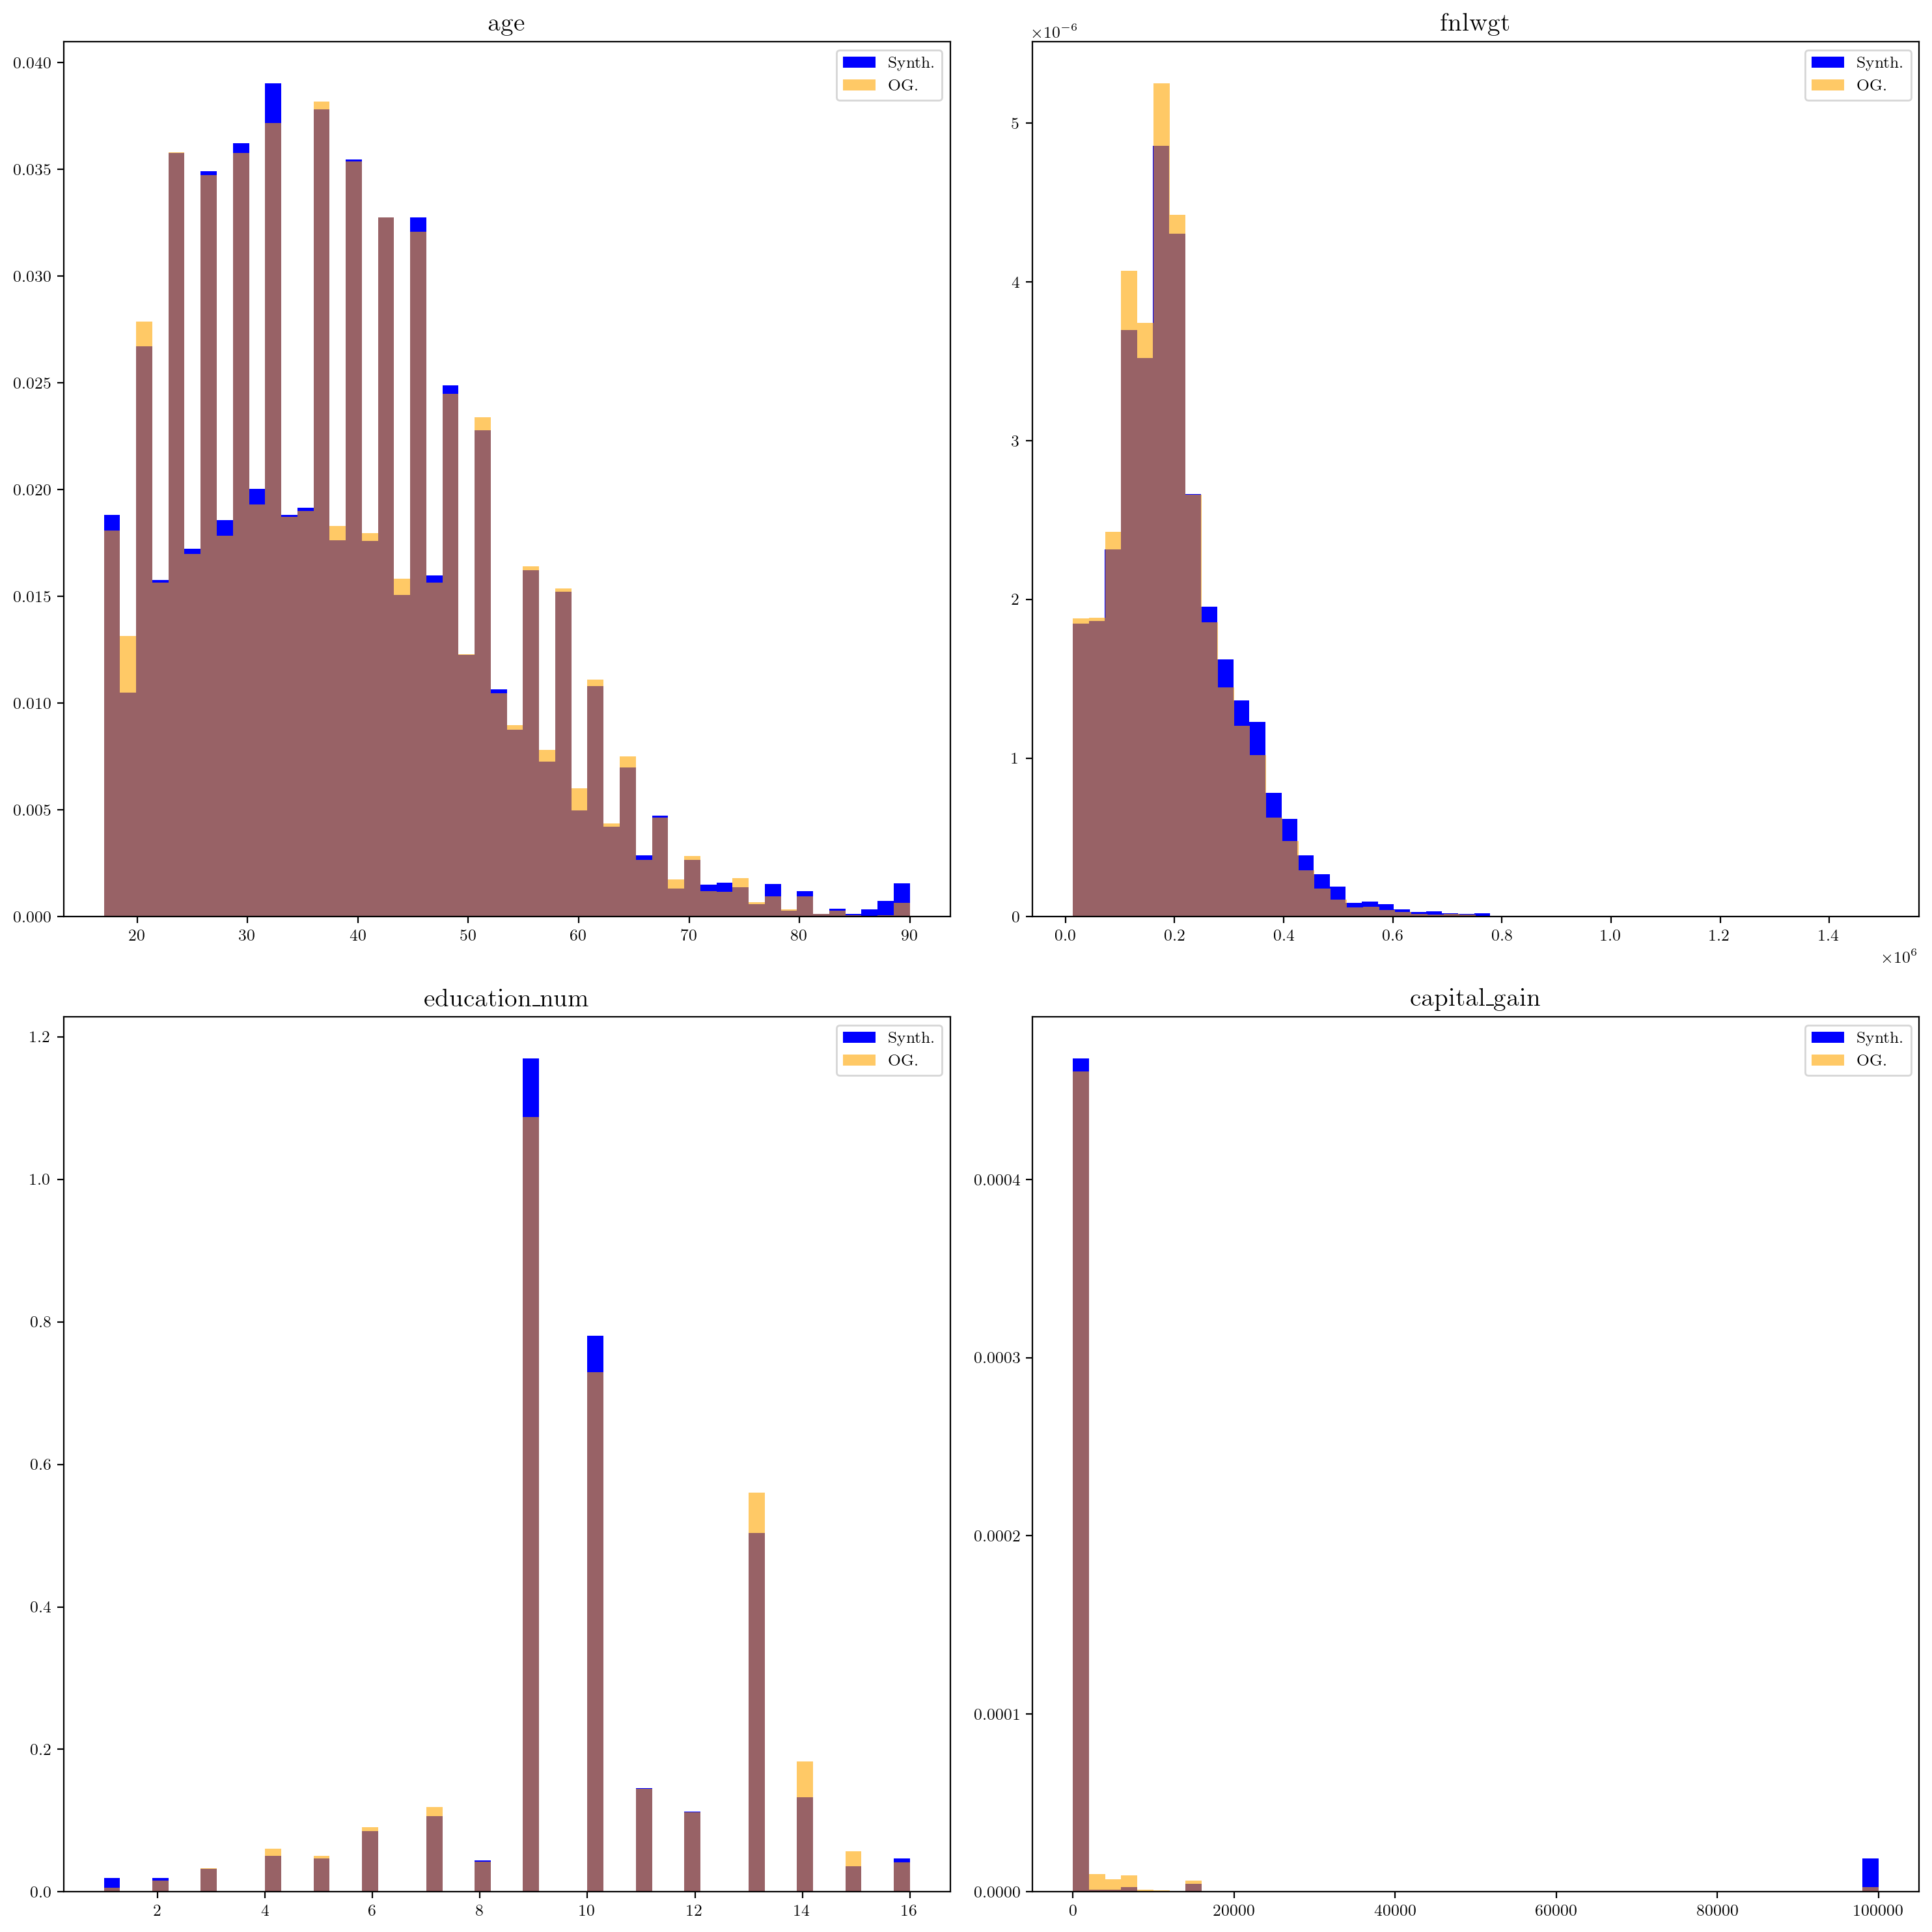

In [13]:
fig, axs = plt.subplots(2,2, figsize = (15,15))
axs = axs.ravel()
for idx, ax in enumerate(axs):
    ax.hist(synthetic_samples[numerical_features[idx]], density = True, color = "b", label = "Synth.", bins = 50)
    ax.hist(X_train[numerical_features[idx]], color = "orange", alpha = 0.6, density = True, label = "OG.", bins = 50)
    ax.legend()
    ax.title.set_text(numerical_features[idx])
plt.tight_layout()

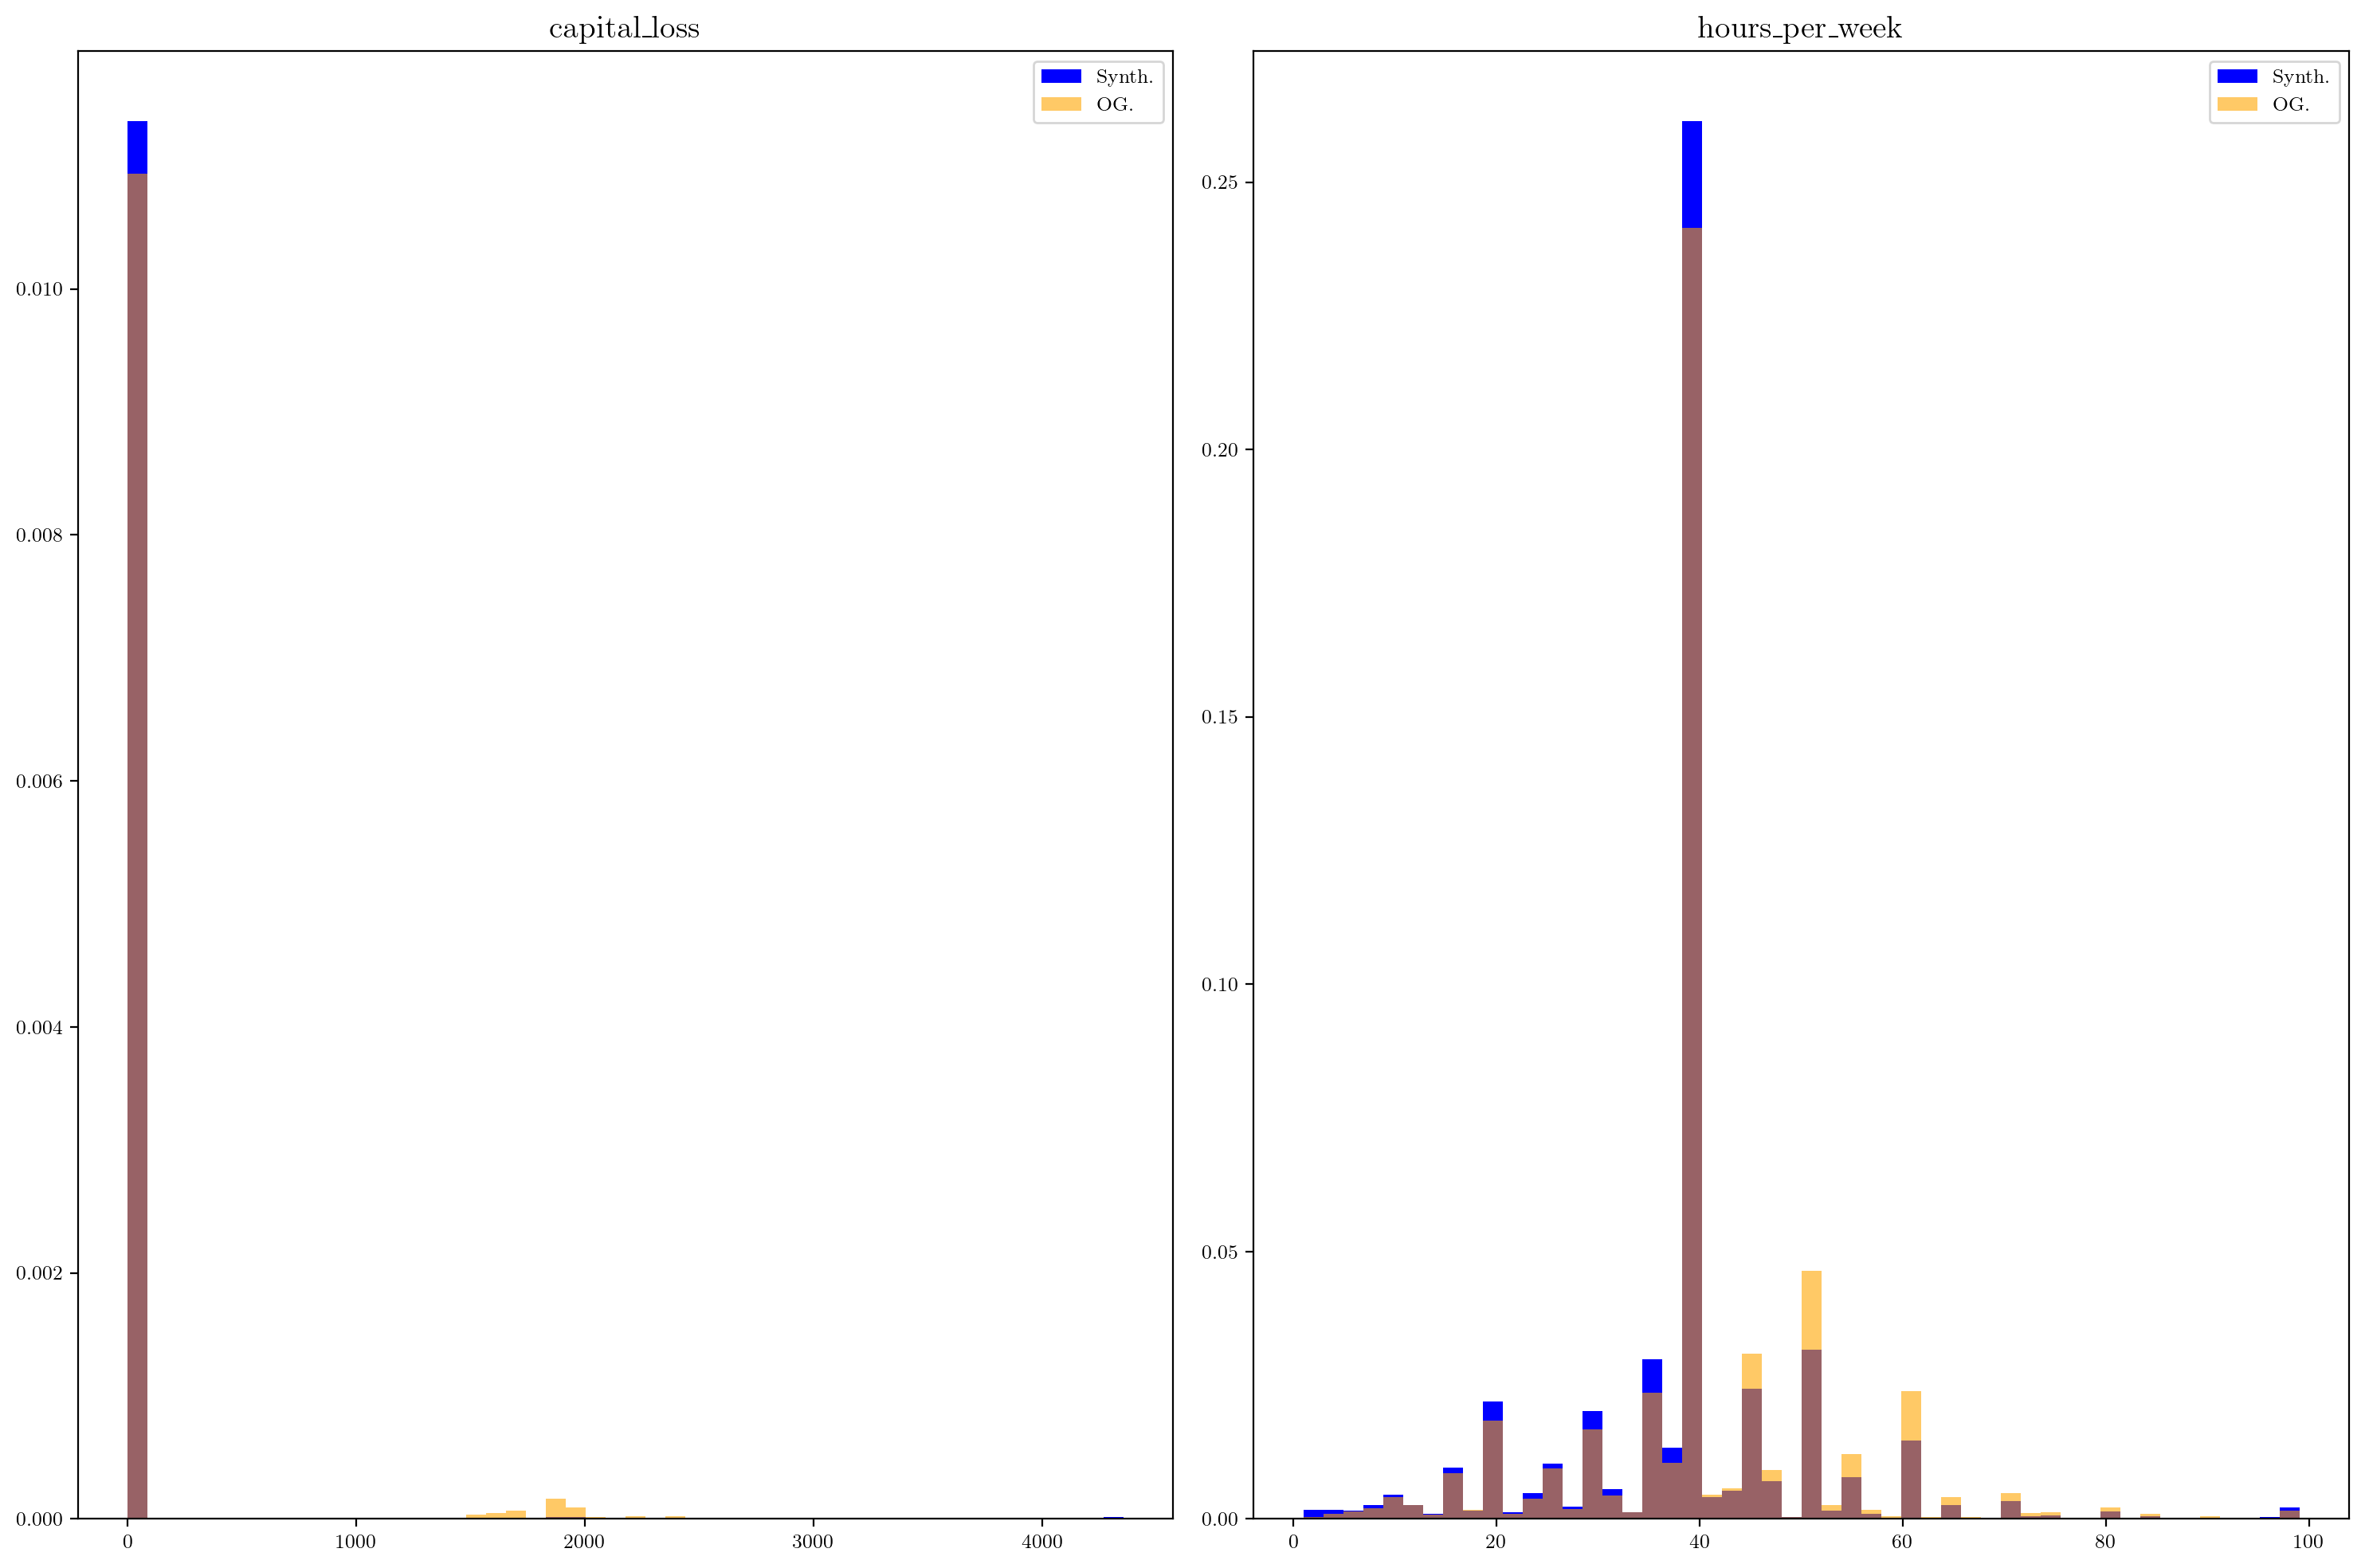

In [14]:
fig, axs = plt.subplots(1,2, figsize = (15,10))
axs = axs.ravel()
for idx, ax in enumerate(axs, start = 4):
    ax.hist(synthetic_samples[numerical_features[idx]], density = True, color = "b", label = "Synth.", bins = 50)
    ax.hist(X_train[numerical_features[idx]], color = "orange", alpha = 0.6, density = True, label = "OG.", bins = 50)
    ax.legend()
    ax.title.set_text(numerical_features[idx])
plt.tight_layout()

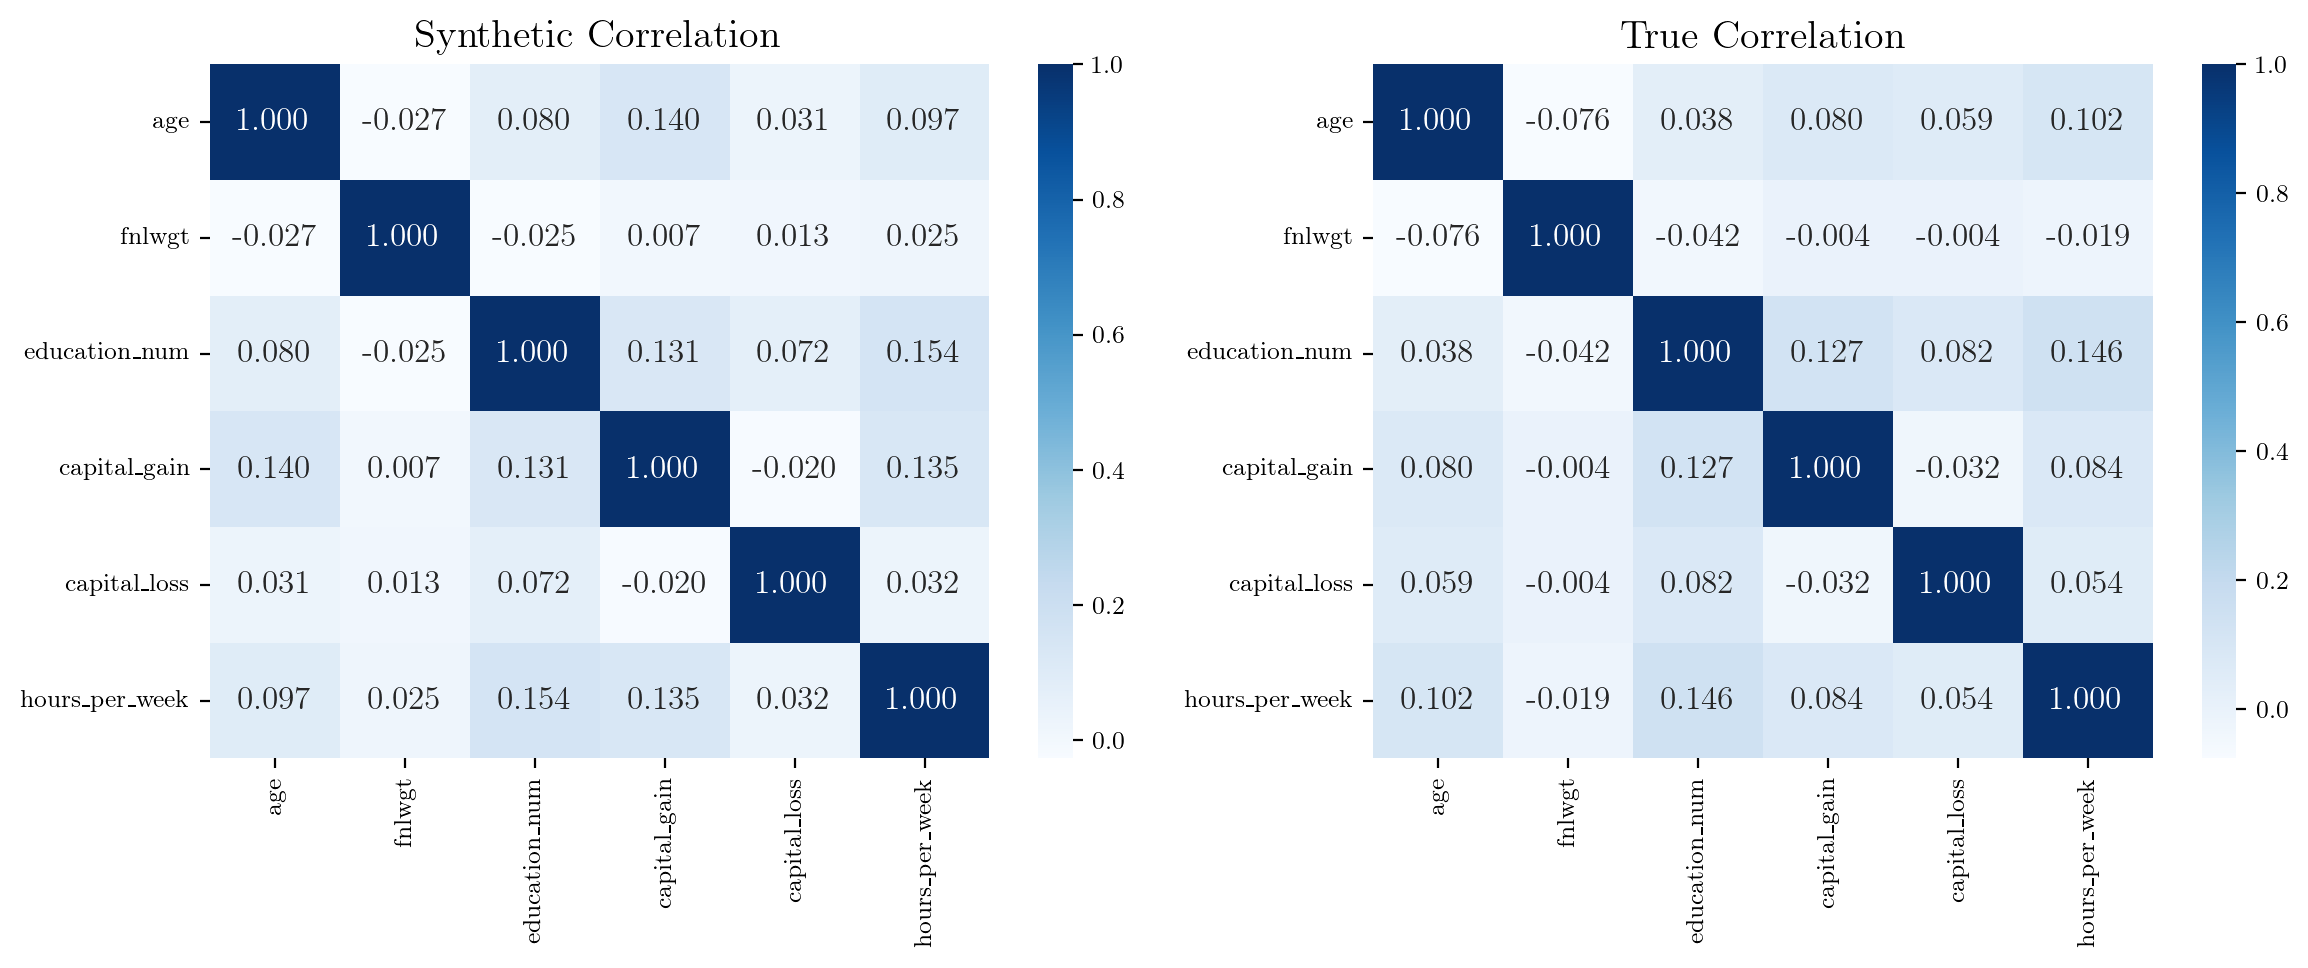

In [15]:
synthetic_corr = synthetic_samples.corr()
true_corr = adult_data.iloc[:,:-1].corr()

fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(synthetic_corr, annot = True, fmt = ".3f", ax = ax[0], cmap = "Blues")
ax[0].set_title("Synthetic Correlation")
sns.heatmap(true_corr, annot = True, fmt = ".3f", ax = ax[1], cmap = "Blues")
ax[1].set_title("True Correlation")
plt.tight_layout()

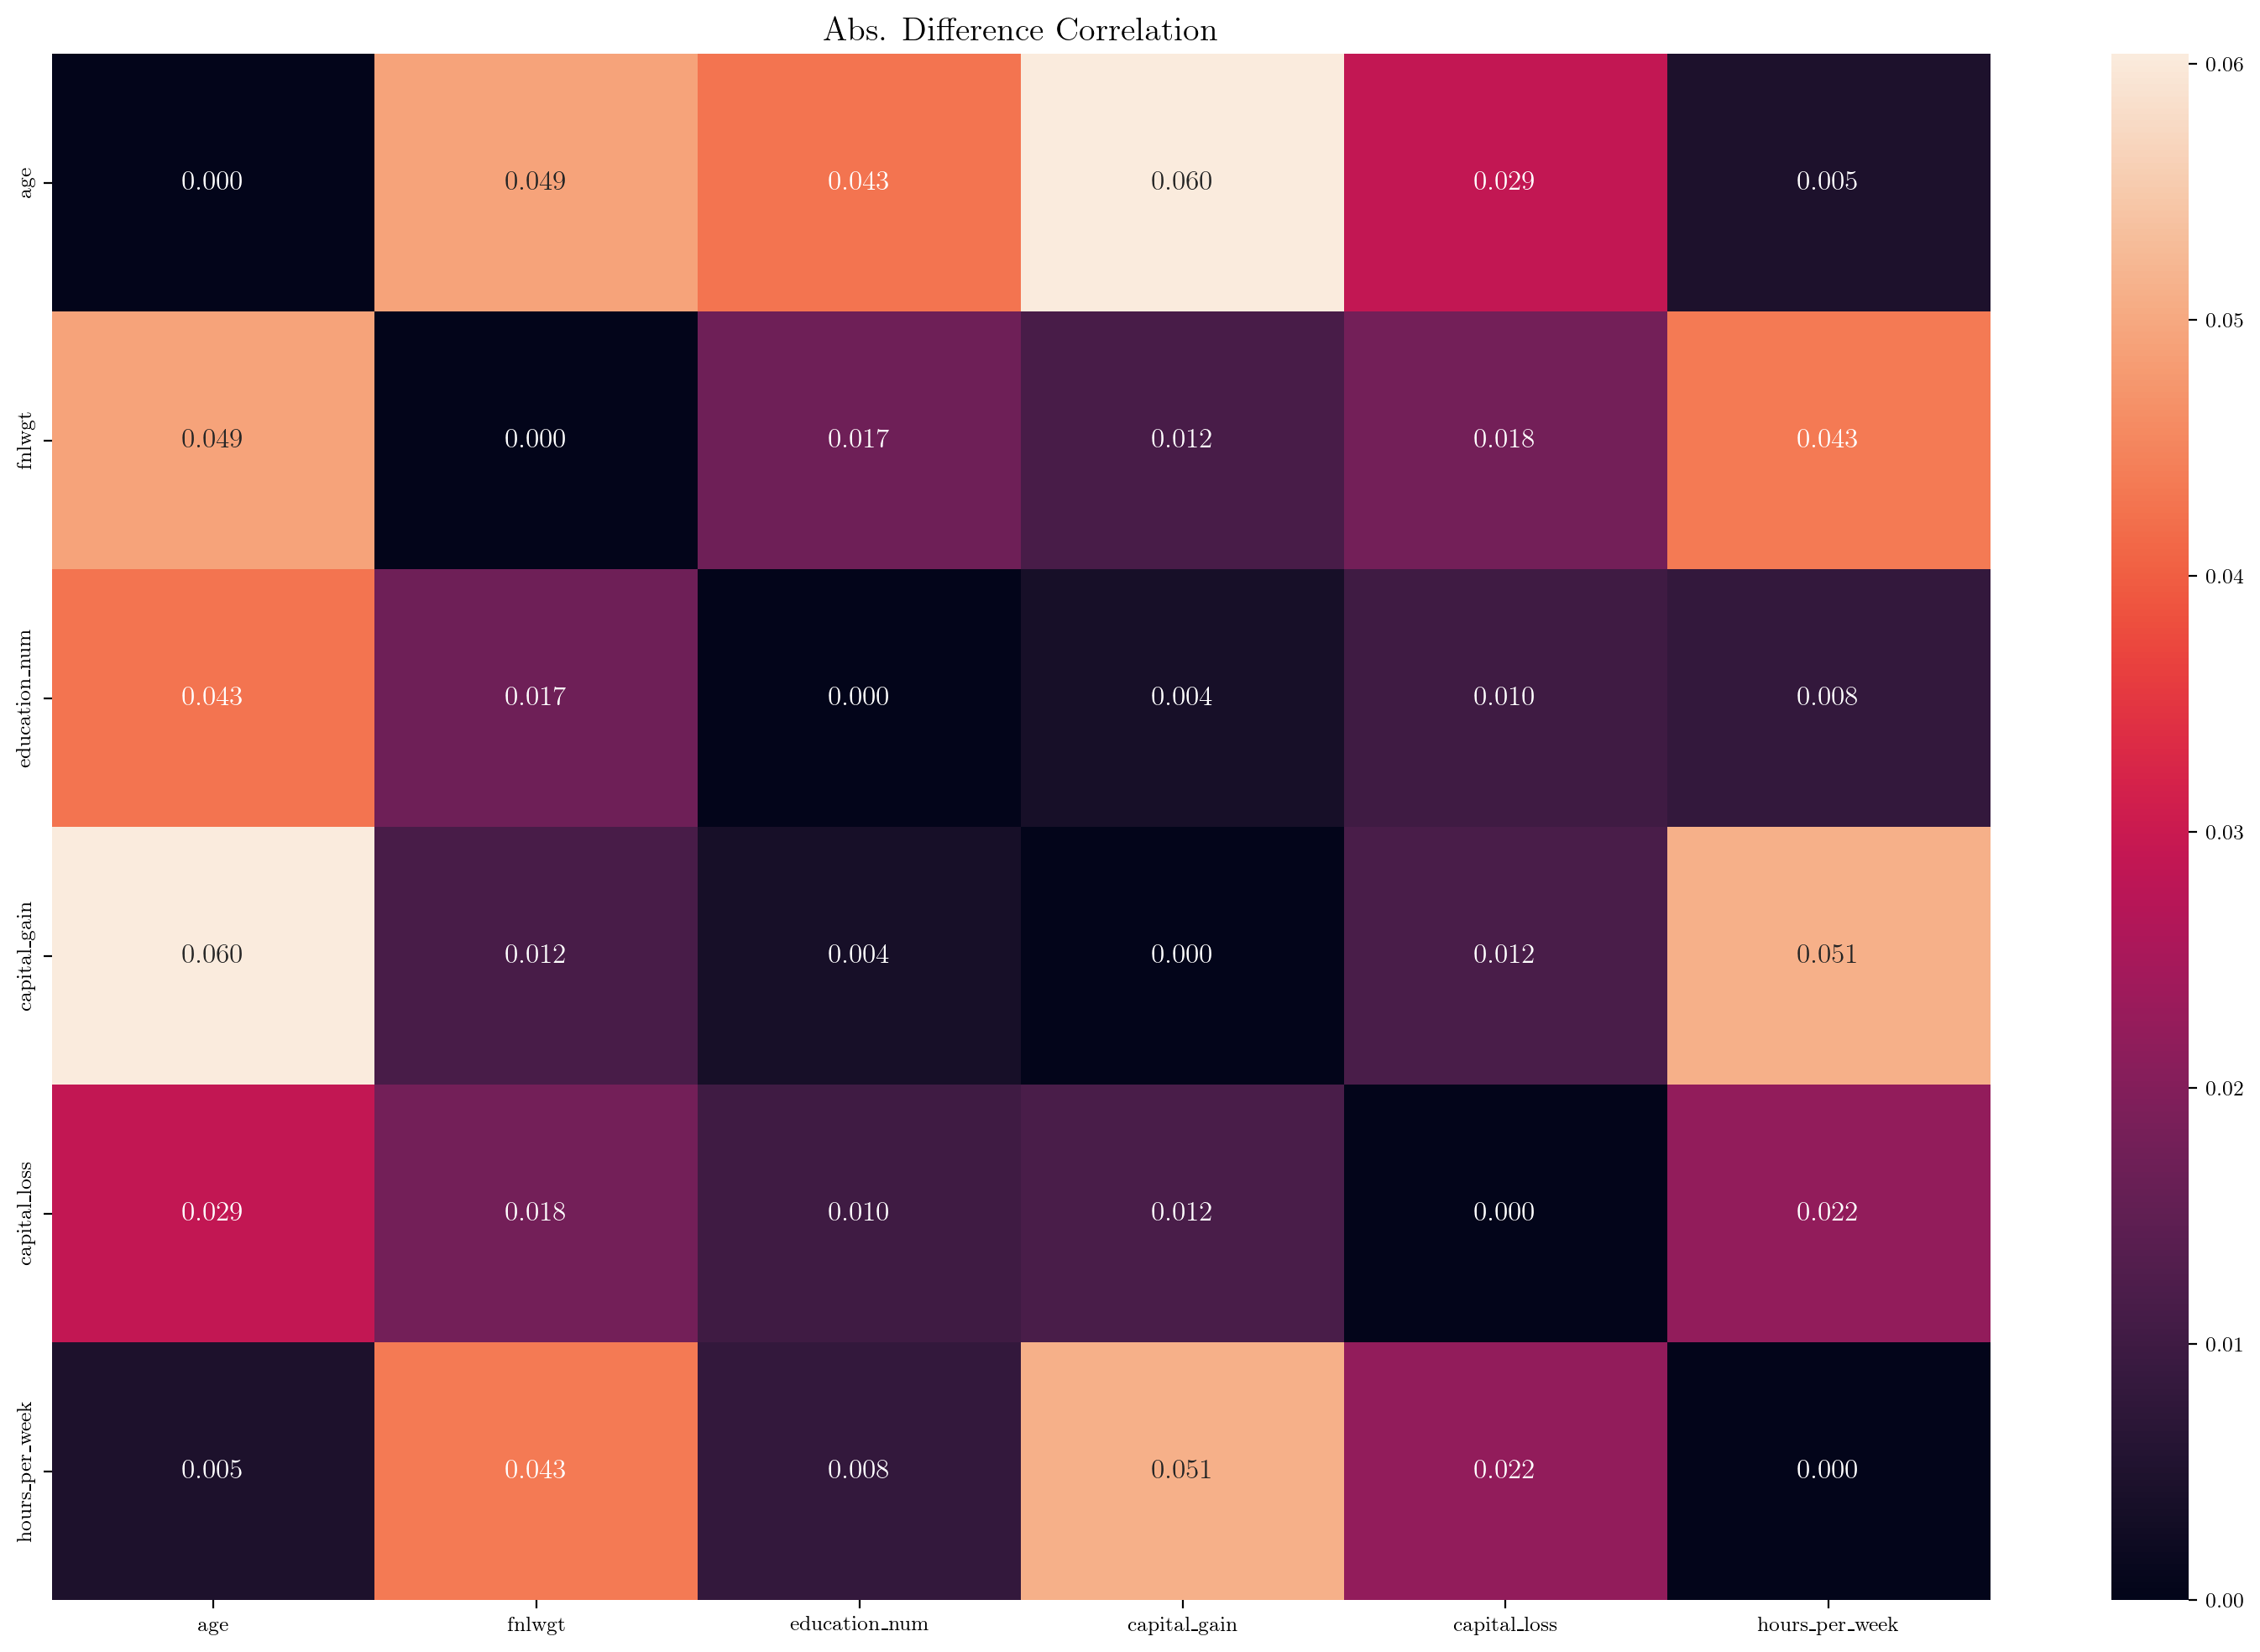

In [16]:
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(np.abs(true_corr - synthetic_corr), annot = True, fmt = ".3f", ax = ax)
ax.set_title("Abs. Difference Correlation")
plt.tight_layout()

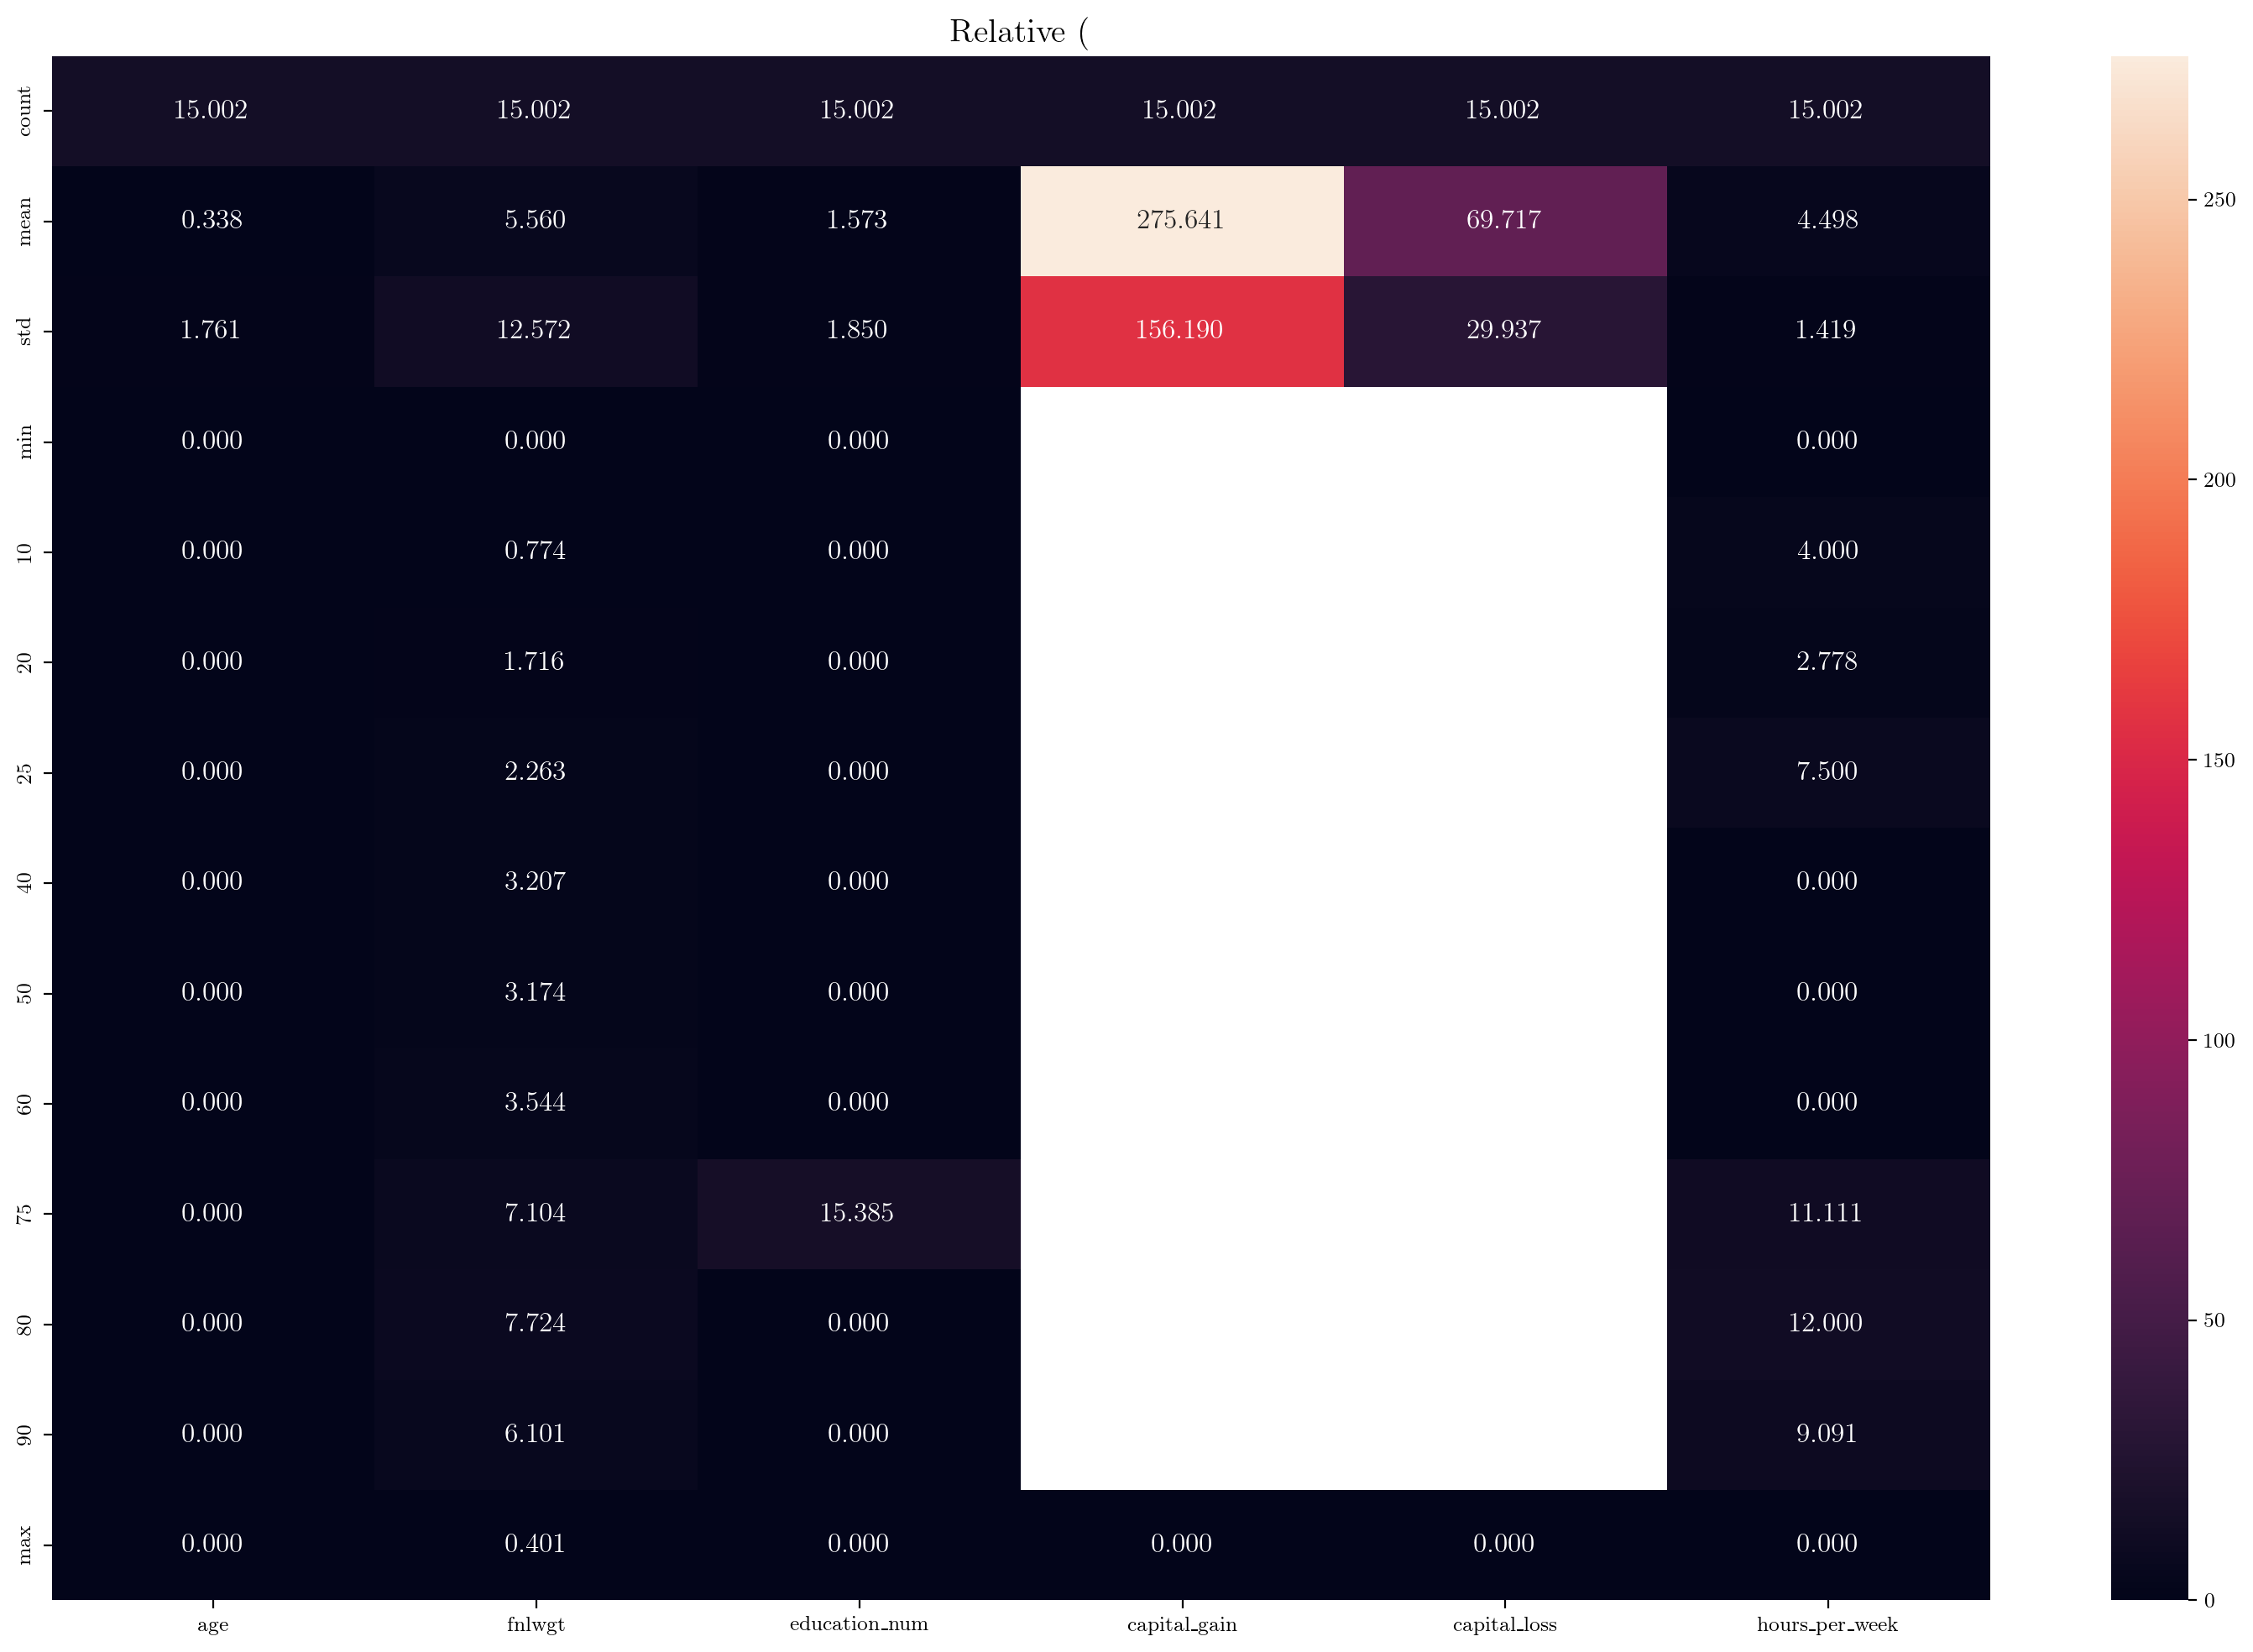

In [17]:
percentiles = [0.1, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.9]
desc_synth = synthetic_samples.describe(percentiles = percentiles)
desc_true = adult_data.iloc[:,:-1].describe(percentiles = percentiles)

fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(np.divide(np.abs(desc_synth - desc_true),desc_true)*100, annot = True, fmt = ".3f", ax = ax)
ax.set_title("Relative (%) Difference in Statistics")
plt.tight_layout()

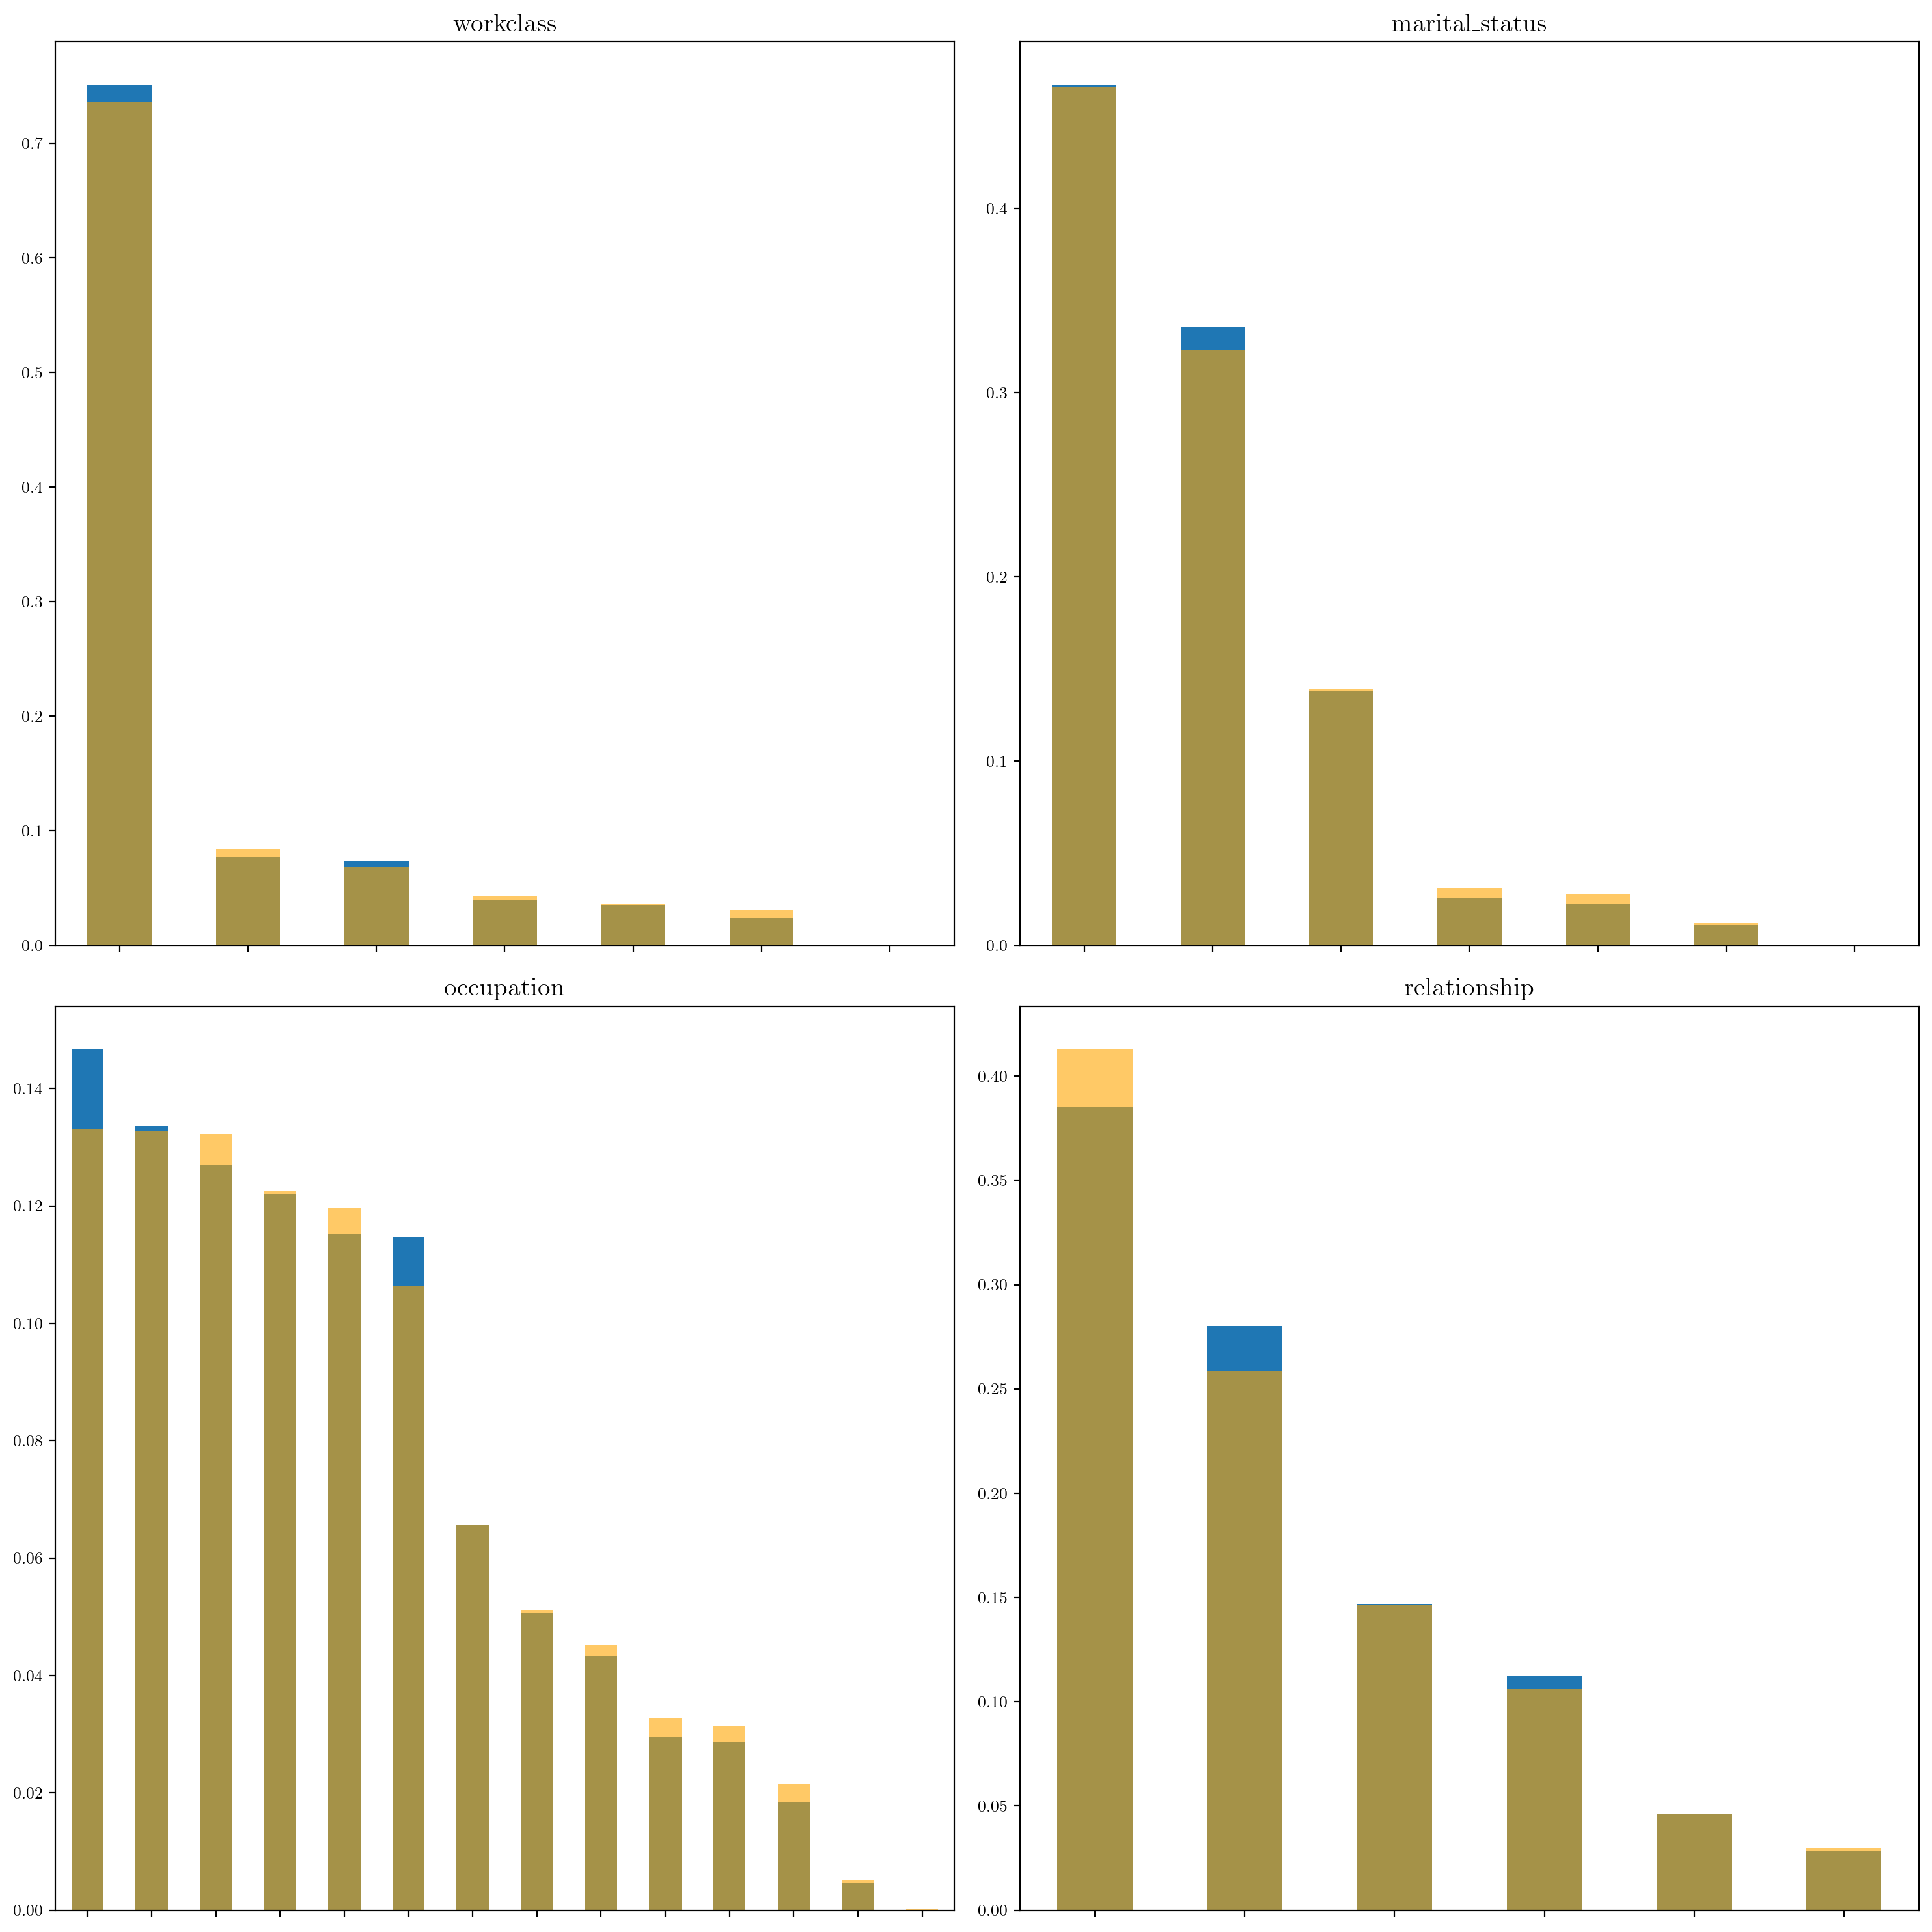

In [21]:
fig, axs = plt.subplots(2,2, figsize = (15, 15))
axs = axs.ravel()
for idx, ax in enumerate(axs):
    (synthetic_samples[categorical_features[idx]].value_counts()/synthetic_samples.shape[0]).plot(kind='bar', ax = ax)
    (adult_data[categorical_features[idx]].value_counts()/adult_data.shape[0]).plot(kind='bar', ax = ax, color = "orange", alpha = 0.6)
    ax.title.set_text(categorical_features[idx])
    ax.xaxis.set_ticklabels([])
plt.tight_layout()

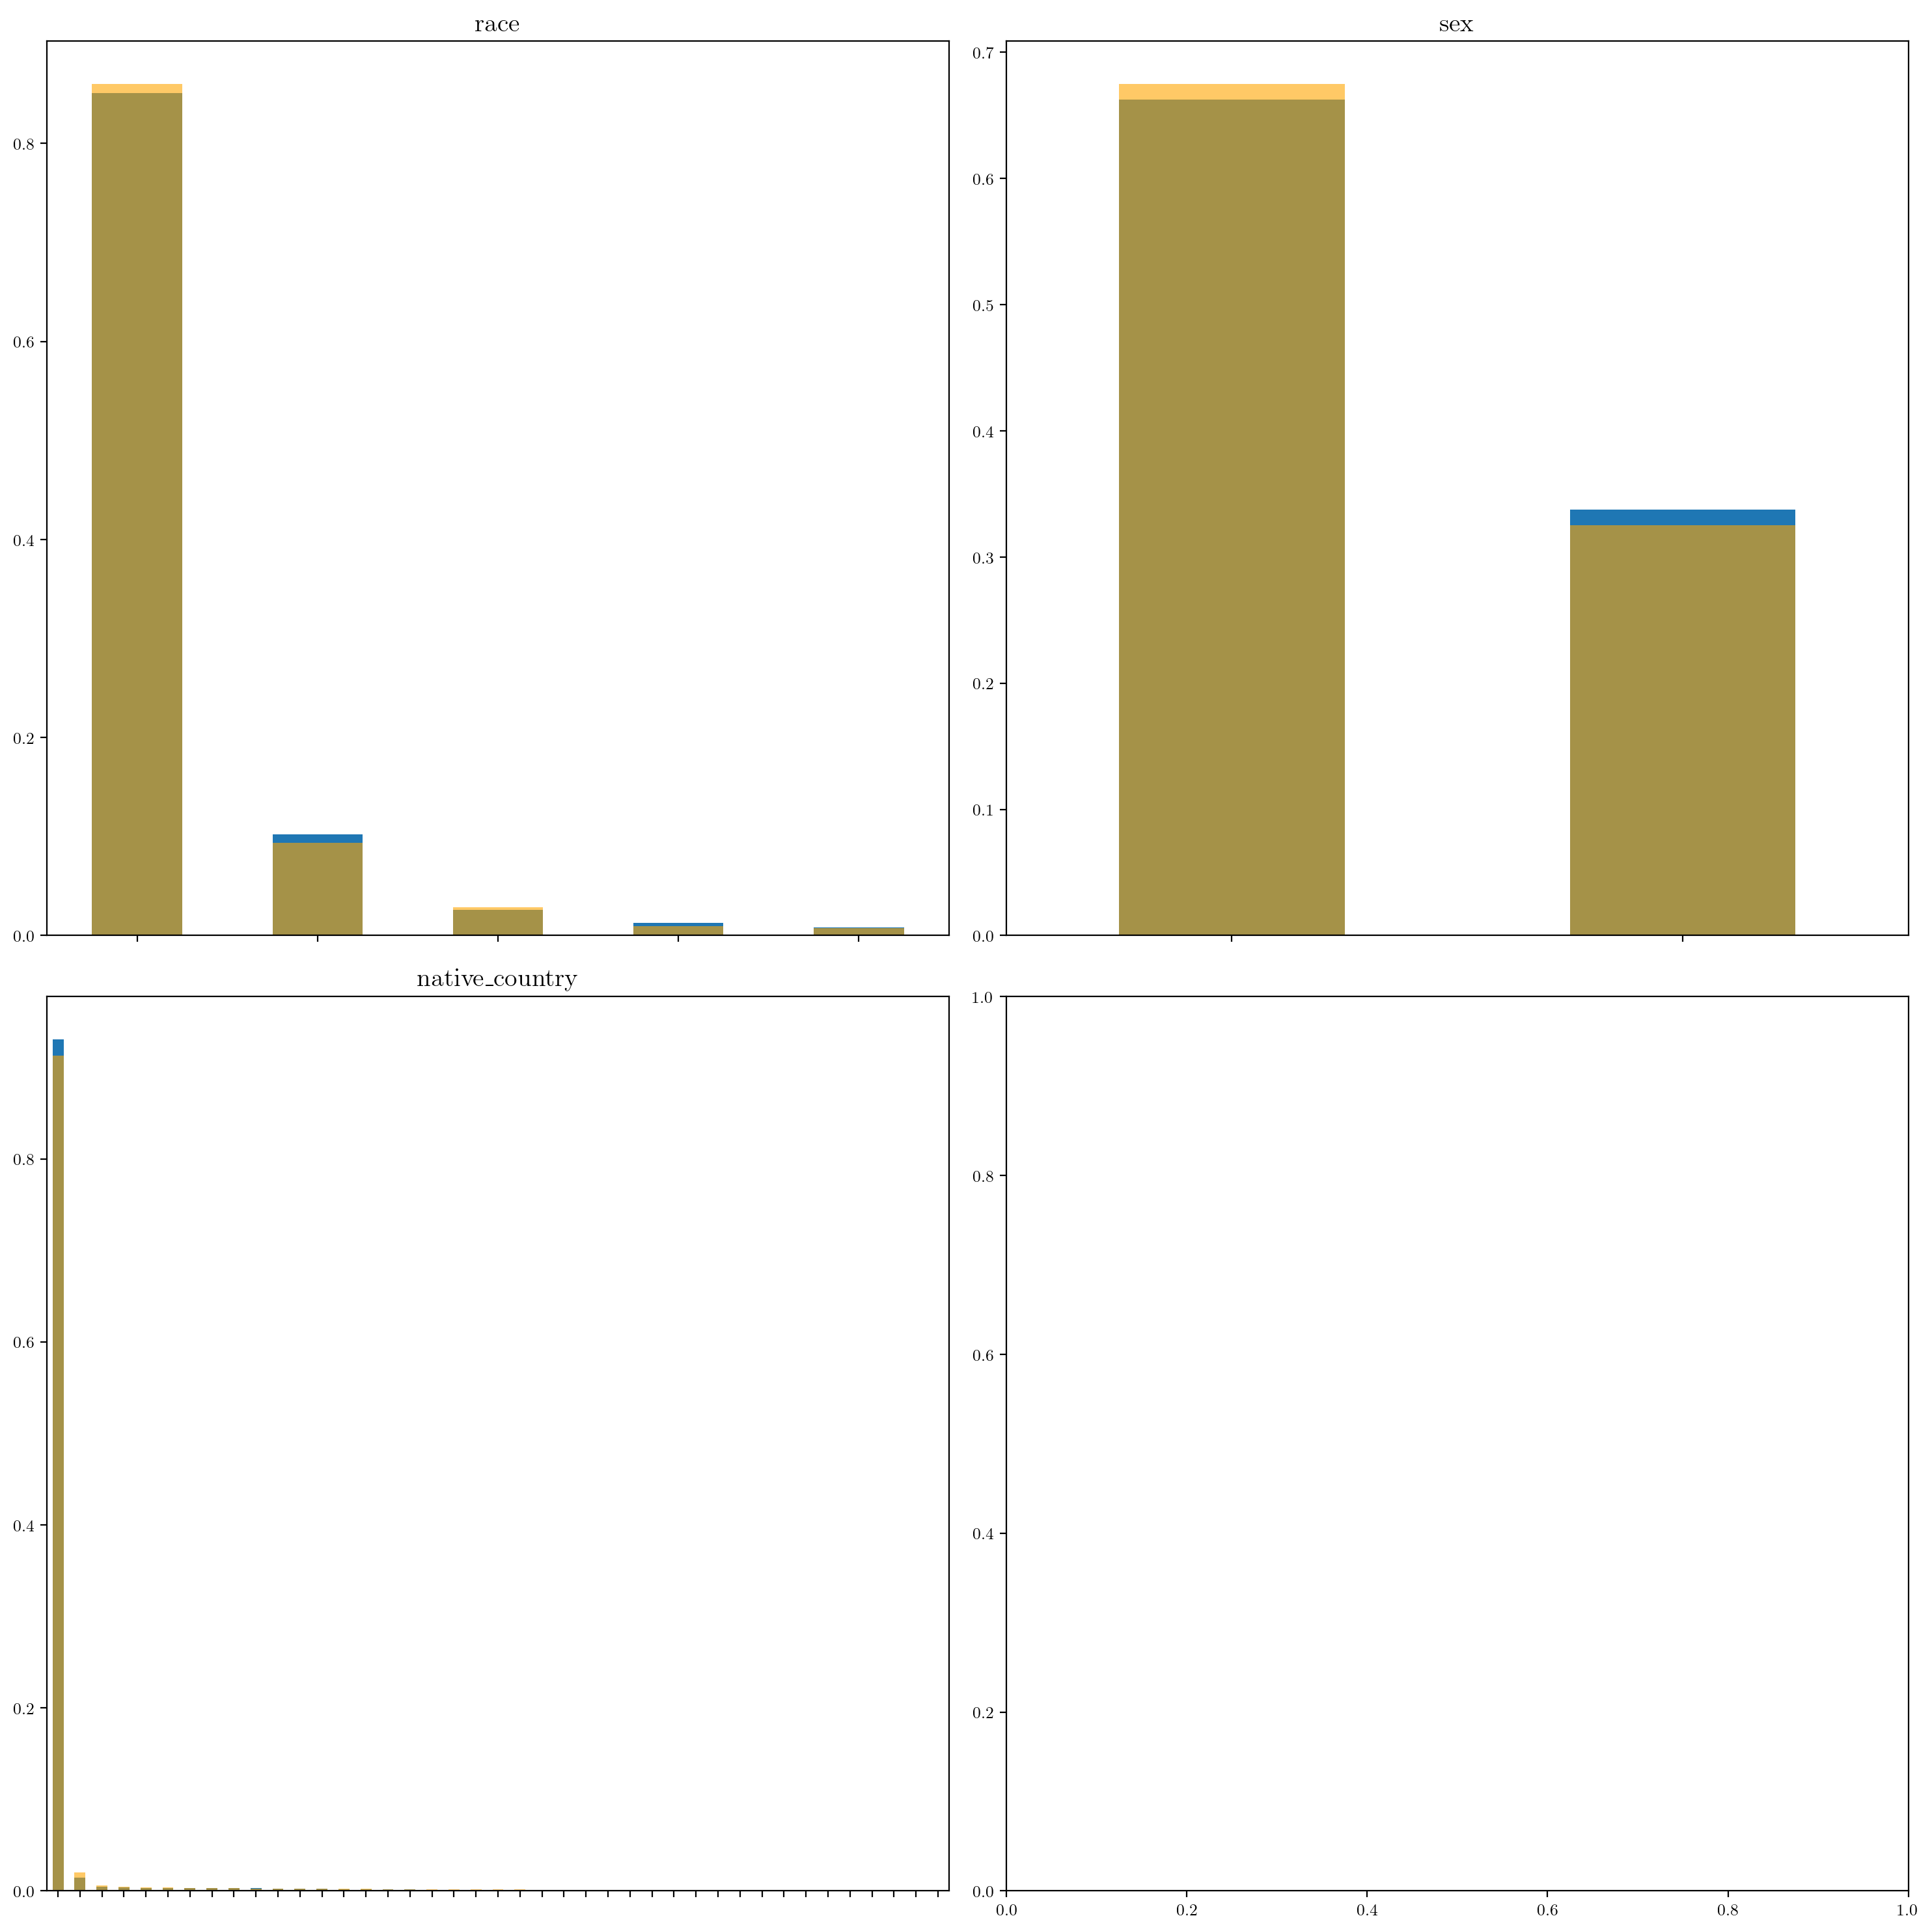

In [22]:
fig, axs = plt.subplots(2,2, figsize = (15, 15))
axs = axs.ravel()
for idx, ax in enumerate(axs, start = 4):
    if idx > len(categorical_features)-1:
        break
    (synthetic_samples[categorical_features[idx]].value_counts()/synthetic_samples.shape[0]).plot(kind='bar', ax = ax)
    (adult_data[categorical_features[idx]].value_counts()/adult_data.shape[0]).plot(kind='bar', ax = ax, color = "orange", alpha = 0.6)
    ax.title.set_text(categorical_features[idx])
    ax.xaxis.set_ticklabels([])
plt.tight_layout()

In [23]:
# Calculate correlations between categorical variables
# using Theil's U statistic.
# https://en.wikipedia.org/wiki/Uncertainty_coefficient
from dython.nominal import associations

synth2 = synthetic_samples.copy()
adult2 = adult_data.iloc[:,:-1].copy()

adult2 = adult2[synth2.columns.tolist()]

synthetic_corr = associations(synth2, nominal_columns=categorical_features, 
            numerical_columns=numerical_features, nom_nom_assoc='theil',
            num_num_assoc='pearson', compute_only = True)["corr"]

true_corr = associations(adult2, nominal_columns=categorical_features, 
            numerical_columns=numerical_features, nom_nom_assoc='theil',
            num_num_assoc='pearson', compute_only = True)["corr"]

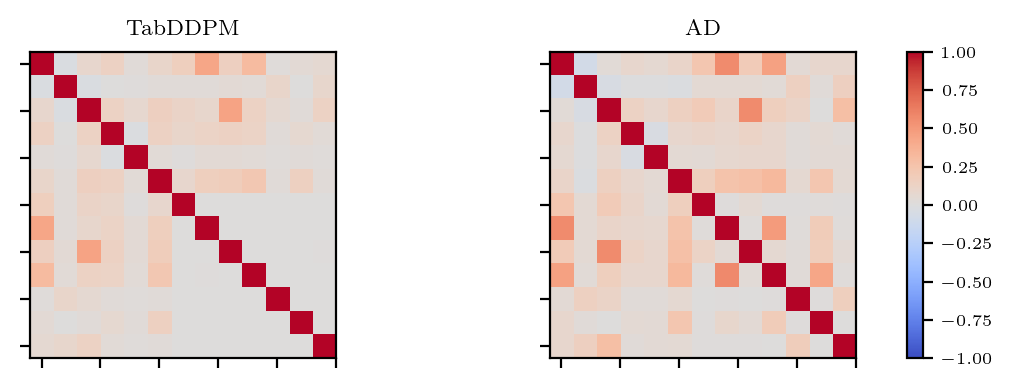

In [128]:
# plot correlations between -1 and 1.
fig, ax = plt.subplots(1,2, figsize = set_size(subplots = (1,2)))
ax[0].imshow(synthetic_corr, cmap = sns.color_palette("coolwarm", as_cmap=True), vmin = -1, vmax = 1)
ax[0].set_title("TabDDPM")
ax[0].xaxis.set_ticklabels([])
ax[0].yaxis.set_ticklabels([])
im = ax[1].imshow(true_corr, cmap = sns.color_palette("coolwarm", as_cmap=True), vmin = -1, vmax = 1)
ax[1].set_title("AD")
ax[1].xaxis.set_ticklabels([])
ax[1].yaxis.set_ticklabels([])
fig.colorbar(im, ax=ax.ravel().tolist())
#plt.tight_layout()
plt.savefig("plots/AD/TabDDPM_Corr_AD.pdf", format="pdf", bbox_inches = "tight") 

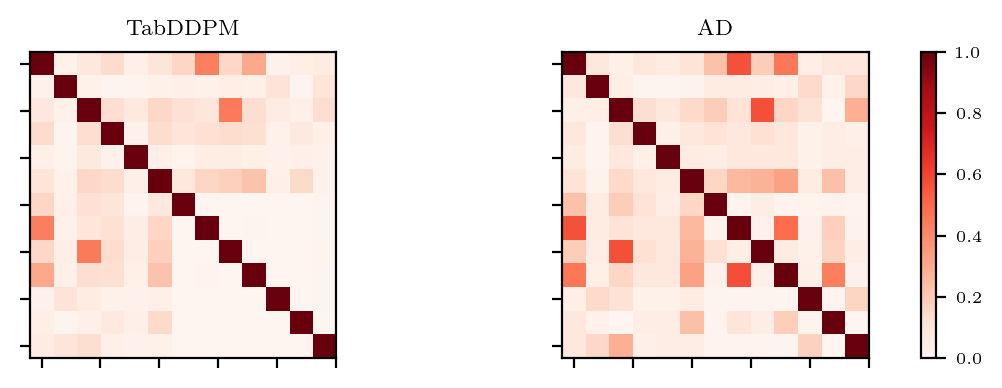

In [129]:
# or plot absolute values (only focus on the strength).
# I think I prefer this one. 
fig, ax = plt.subplots(1,2, figsize = set_size(subplots = (1,2)))
ax[0].imshow(abs(synthetic_corr), cmap = "Reds", vmin = 0, vmax = 1)
ax[0].set_title("TabDDPM")
ax[0].xaxis.set_ticklabels([])
ax[0].yaxis.set_ticklabels([])
im = ax[1].imshow(abs(true_corr), cmap = "Reds", vmin = 0, vmax = 1)
ax[1].set_title("AD")
ax[1].xaxis.set_ticklabels([])
ax[1].yaxis.set_ticklabels([])
fig.colorbar(im, ax=ax.ravel().tolist())
#plt.tight_layout()
plt.savefig("plots/AD/TabDDPM_Abs_Corr_AD.pdf", format="pdf", bbox_inches = "tight") 

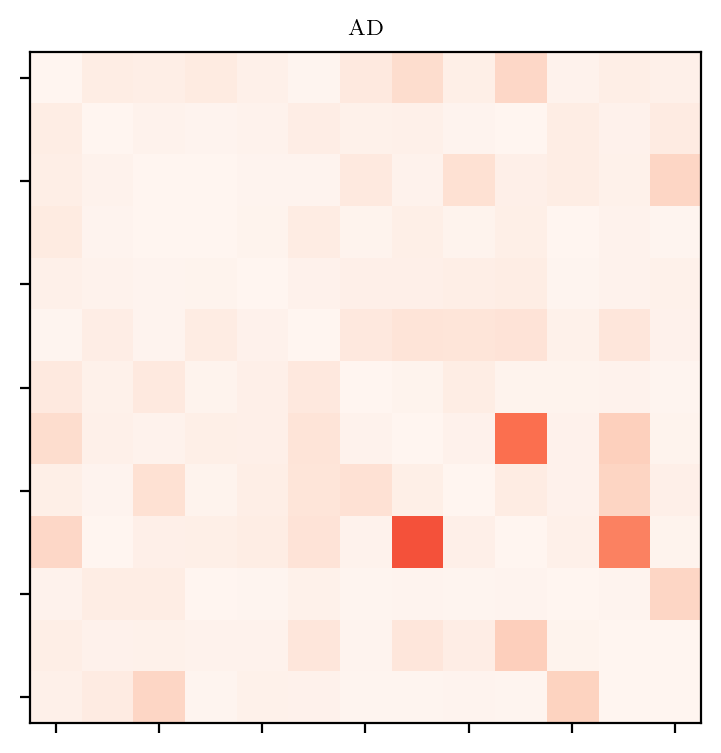

In [130]:
# or plot absolute difference between correlations of both data sets (true - synthetic).
# This is also very nice.
fig, ax = plt.subplots(1,1, figsize = set_size())
ax.imshow(np.abs(true_corr - synthetic_corr), cmap = "Reds", vmin = 0, vmax = 1)
ax.set_title("AD")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
#plt.tight_layout()
plt.savefig("plots/AD/TabDDPM_Abs_Diff_Corr_AD.pdf", format="pdf", bbox_inches = "tight") 

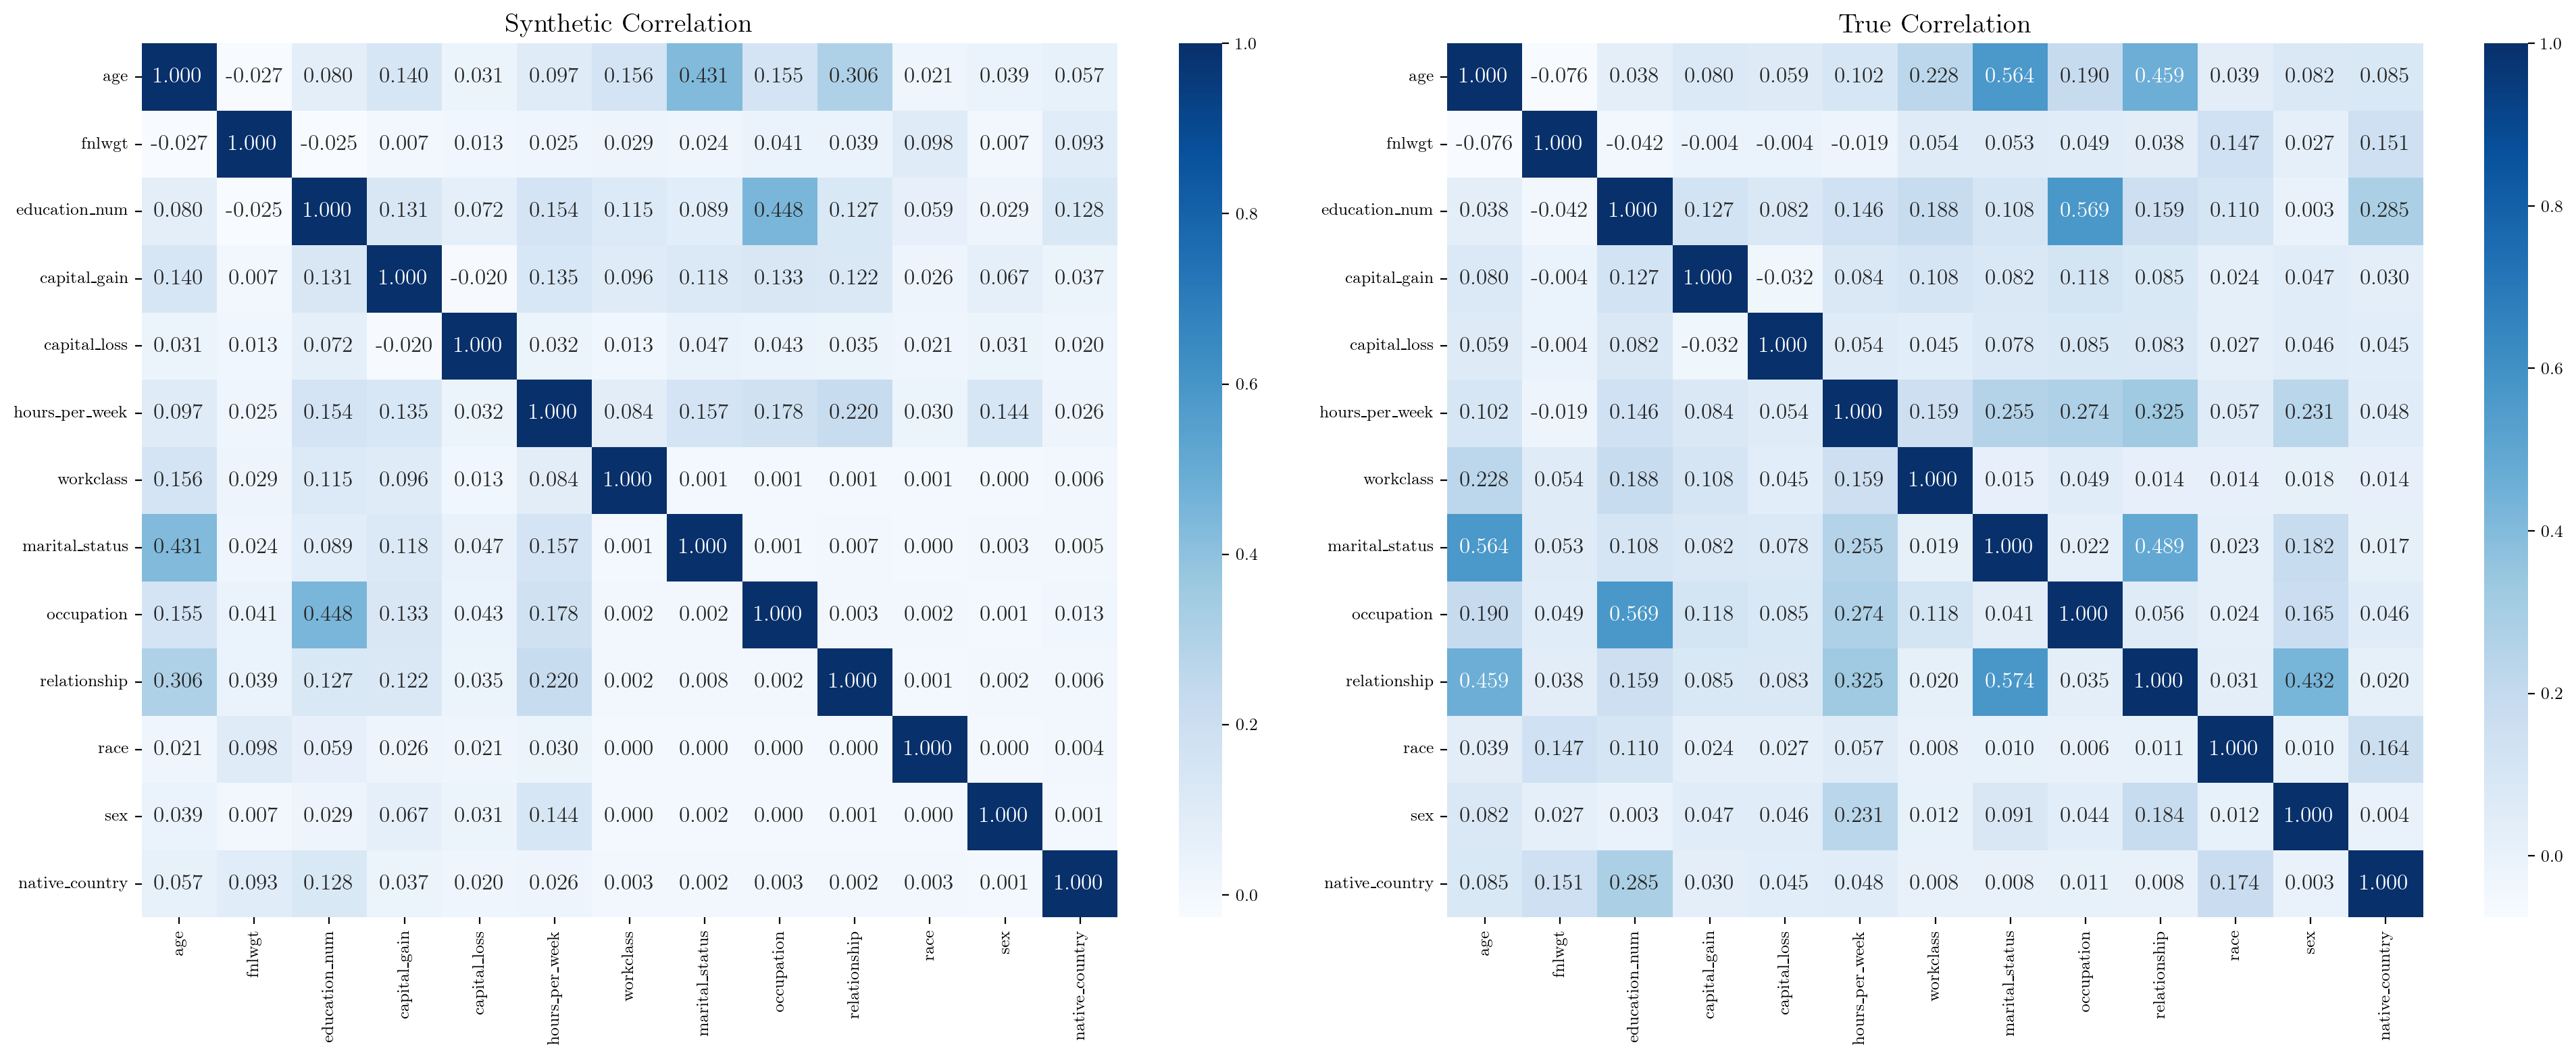

In [56]:
# Make sure that the features are in the same order. 
fig, ax = plt.subplots(1,2, figsize = (20,8))
sns.heatmap(synthetic_corr, annot = True, fmt = ".3f", ax = ax[0], cmap = "Blues")
ax[0].set_title("Synthetic Correlation")
sns.heatmap(true_corr, annot = True, fmt = ".3f", ax = ax[1], cmap = "Blues")
ax[1].set_title("True Correlation")

#plt.savefig("TabDDPM_Corr_AD.pdf", format="pdf", bbox_inches = "tight")  
plt.tight_layout()

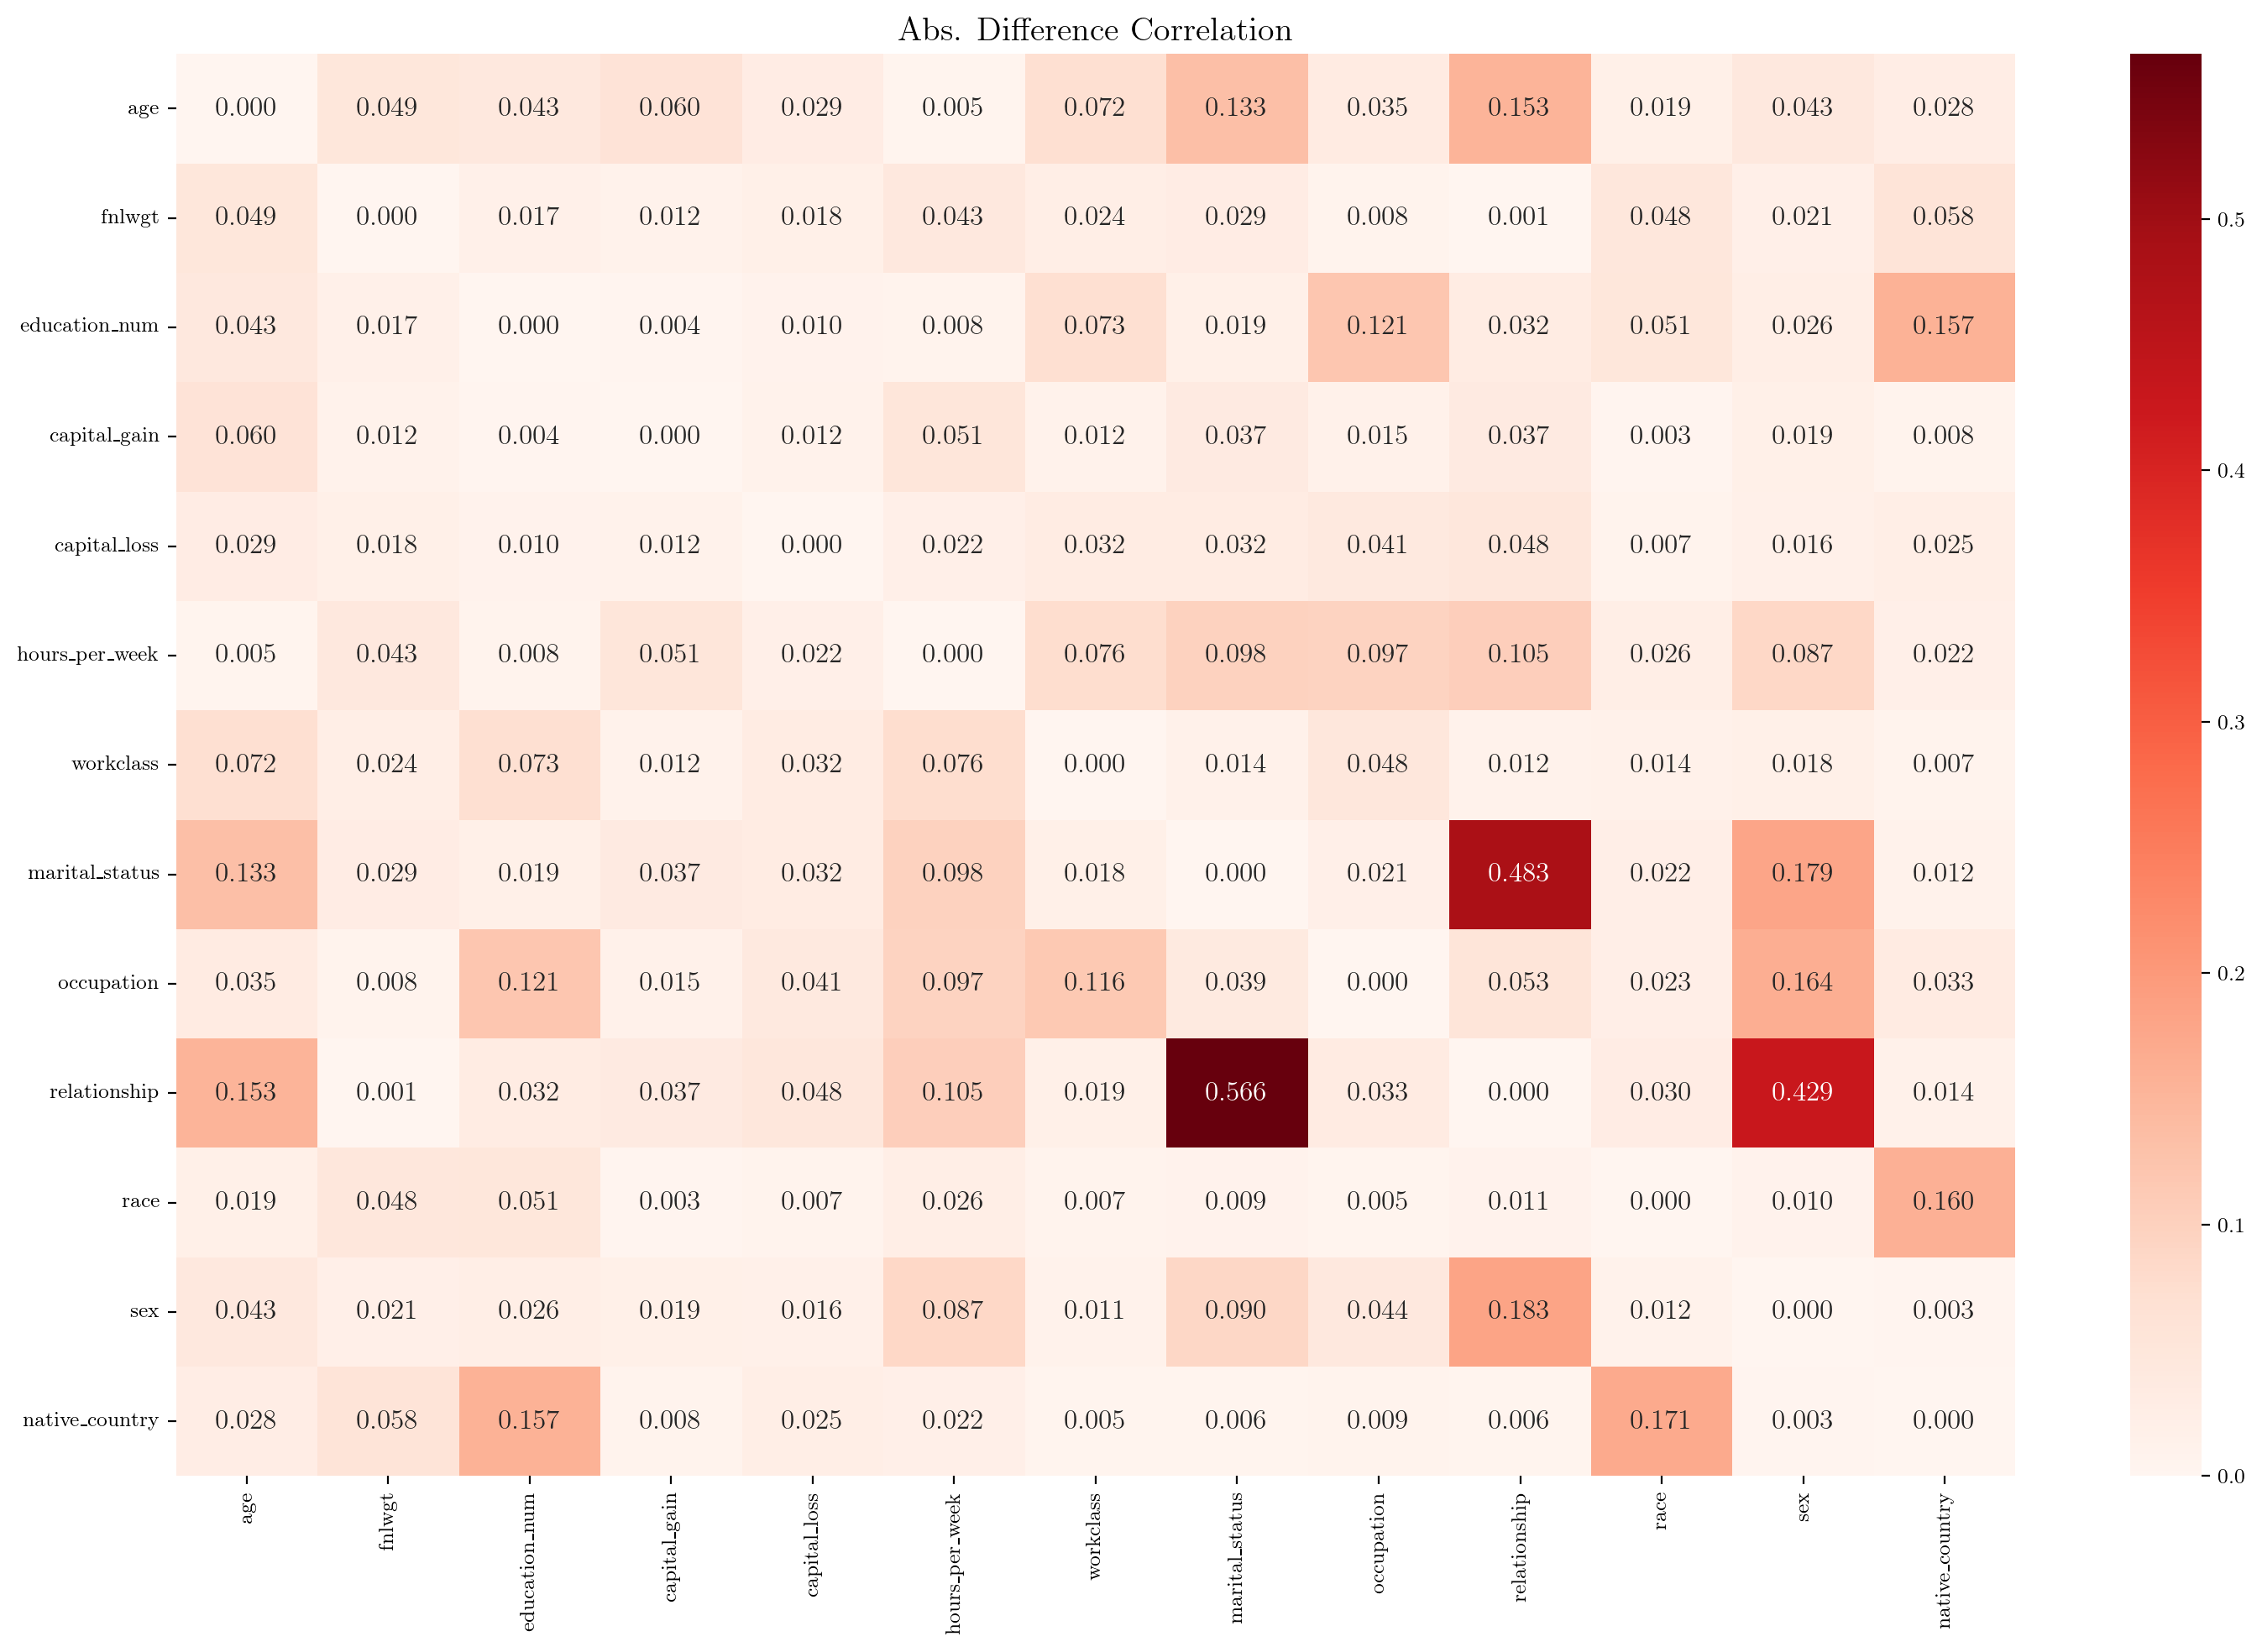

In [85]:
# Plot absolute difference between them.
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(np.abs(true_corr - synthetic_corr), annot = True, fmt = ".3f", ax = ax, cmap = "Reds")
ax.set_title("Abs. Difference Correlation")
plt.tight_layout()

In [ ]:
# Calculate correlations between categorical and numerical variables,
# using the correlation Ratio.

In [ ]:
# Good source:
# https://medium.com/the-researchers-guide/generate-numerical-correlation-and-nominal-association-plots-using-python-c8548aa4a663

In [ ]:
# All the three are done automatically above!

## Make plots for thesis below

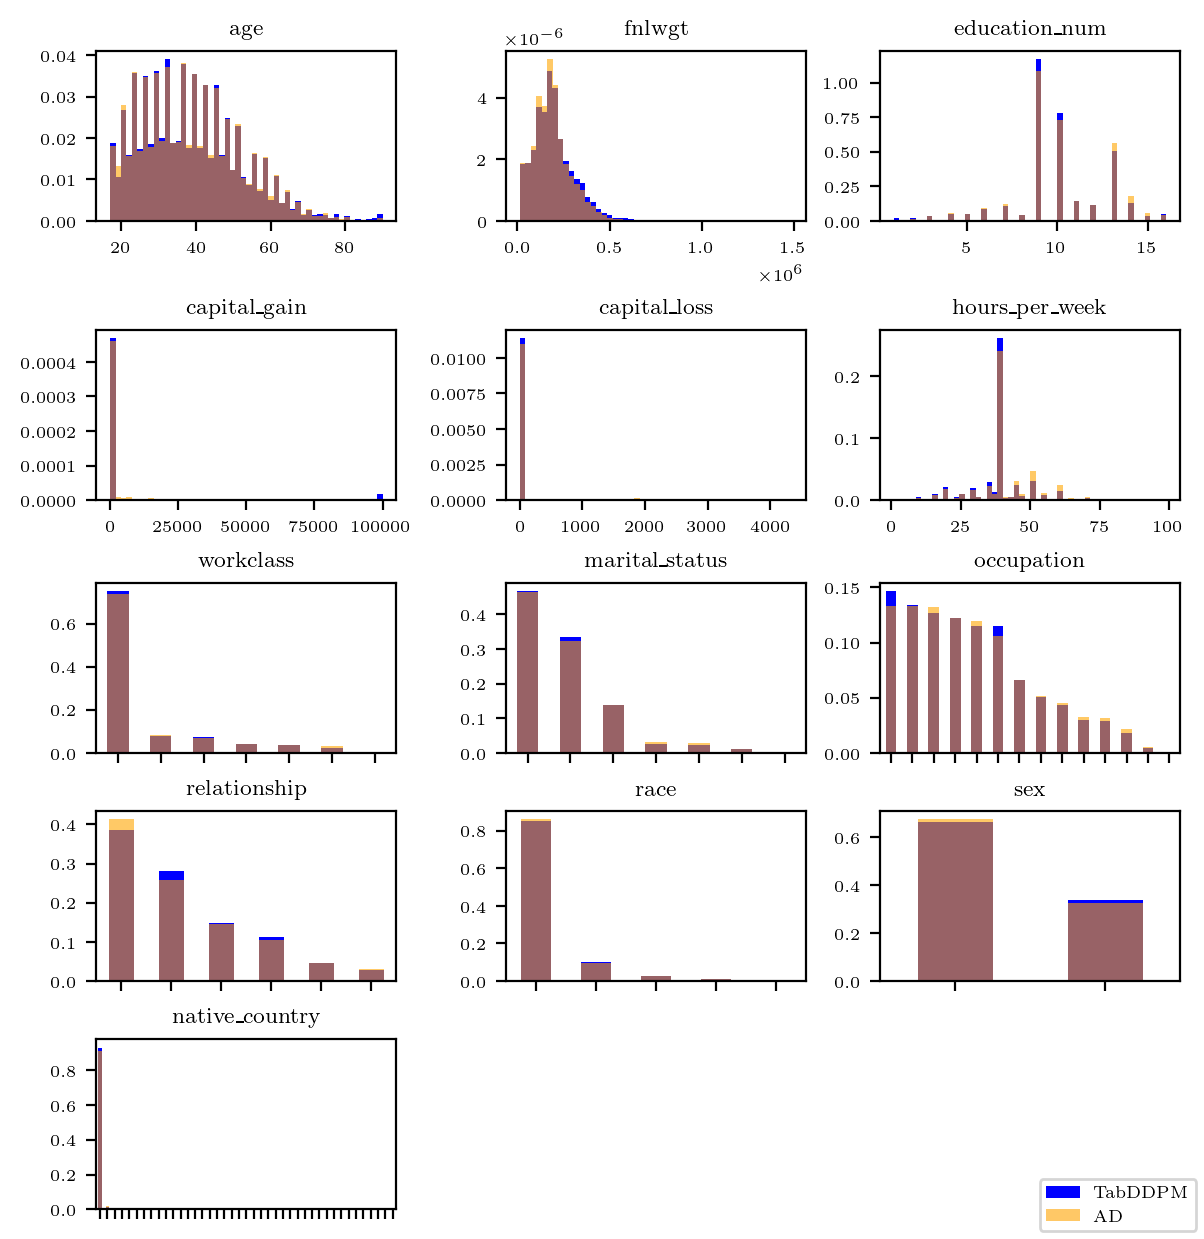

In [133]:
plt.style.use("tex.mplstyle")
fig, axes = plt.subplots(5,3, figsize = set_size(subplots = (5,3)))
axs = axes.ravel()
features = numerical_features + categorical_features
for idx, ax in enumerate(axs):
    if idx > len(features)-1:
        break
    if idx in range(len(numerical_features)):
        ax.hist(synthetic_samples[features[idx]], density = True, color = "b", label = "TabDDPM", bins = 50)
        ax.hist(X_train[features[idx]], color = "orange", alpha = 0.6, density = True, label = "AD", bins = 50)
        #ax.legend()
        ax.title.set_text(features[idx])
    elif idx in range(len(numerical_features),len(numerical_features) + len(categorical_features)):
        (synthetic_samples[features[idx]].value_counts()/synthetic_samples.shape[0]).plot(kind='bar', ax = ax, color = "b", label = "TabDDPM")
        (adult_data[features[idx]].value_counts()/adult_data.shape[0]).plot(kind='bar', ax = ax, color = "orange", alpha = 0.6, label = "AD")
        ax.title.set_text(features[idx])
        ax.xaxis.set_ticklabels([])
        #ax.legend()
    
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc = "lower right")
axes[4,1].set_axis_off()
axes[4,2].set_axis_off()
#plt.tight_layout()
# Vi mangler å plotte responsen, 
# som må genereres først!

plt.savefig("plots/AD/TabDDPM_Qual_AD.pdf", format="pdf", bbox_inches = "tight")  
    

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass,marital_status,occupation,relationship,race,sex,native_country
age,1.000000,0.075792,0.037623,0.079683,0.059351,0.101992,0.228118,0.564323,0.190133,0.459297,0.039314,0.082053,0.085234
fnlwgt,0.075792,1.000000,0.041993,0.004110,0.004349,0.018679,0.053785,0.053437,0.049354,0.037692,0.146655,0.027240,0.150943
education_num,0.037623,0.041993,1.000000,0.126907,0.081711,0.146206,0.188008,0.107838,0.569401,0.158699,0.109975,0.003417,0.285181
capital_gain,0.079683,0.004110,0.126907,1.000000,0.032102,0.083880,0.108063,0.081589,0.118264,0.085196,0.023586,0.047444,0.029826
capital_loss,0.059351,0.004349,0.081711,0.032102,1.000000,0.054195,0.044885,0.078047,0.084629,0.083241,0.027187,0.046457,0.044734
hours_per_week,0.101992,0.018679,0.146206,0.083880,0.054195,1.000000,0.159330,0.255254,0.274326,0.325244,0.056516,0.231425,0.048124
workclass,0.228118,0.053785,0.188008,0.108063,0.044885,0.159330,1.000000,0.014852,0.049394,0.013595,0.014196,0.018420,0.013643
marital_status,0.564323,0.053437,0.107838,0.081589,0.078047,0.255254,0.019060,1.000000,0.021920,0.489456,0.022622,0.182368,0.017406
occupation,0.190133,0.049354,0.569401,0.118264,0.084629,0.274326,0.118304,0.040912,1.000000,0.055780,0.024392,0.165215,0.046339
relationship,0.459297,0.037692,0.158699,0.085196,0.083241,0.325244,0.020455,0.573860,0.035041,1.000000,0.030637,0.431976,0.019761
